# Проект Покупательская активность

Настоящий проект разработан для решения задачи персонализации предложений постоянным клиентам интернет-магазина "В один клик" для увеличения покупательской активности.

Для решения этой задачи сформулирован следующий подход:
1. Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Собрать данные по клиентам по следующим группам:
    1) Коммуникация с клиентом:
        - Тип сервиса;
        - Разрешение на сообщения;
        - Маркетинг 6 месяцев;
        - Маркетинг текущего месяца;
        - Длительность истории с клиентом.
    2) Продуктовое поведение:
        - Наиболее частая категория продукта в заказе;
        - Среднее число просматриваемых категорий продуктов за визит;
        - Число неоплаченных продуктов в корзине за последние 3 месяца;
    3) Финансовое поведение:
        - Разница в выручке предыдущего и предпредыдущего месяца;
        - Разница в выручке текущего и предыдущего месяца;
        - Выручка в текущем месяце.
    4) Поведение на сайте:
        - Время на сайте за прошлый год;
        - Время на сайте за предыдущий месяц;
        - Время на сайте за текущий месяц;
        - Минут за визит;
        - Число страниц за визит;
        - Сбои сайта.

Задачи проекта:
1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
# Установка библиотек нужных версий для Практикума
!pip install -U numba -q
!pip install phik -q
!pip install -U scikit-learn -q
!pip install shap -q
!pip install matplotlib==3.5 -q
!pip install numpy==1.23 -q

In [2]:
# Импорт необходимых библиотек, классов и фукнций
import time
from warnings import simplefilter
from typing import Union, Optional

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np
import shap
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Определение констант
RANDOM_STATE = 42

# игнорировать все future warnings
simplefilter(action='ignore', category=FutureWarning)

## Загрузка данных

### Поведение покупателя

In [4]:
market_file = pd.read_csv("https://code.s3.yandex.net/datasets/market_file.csv")
market_file.info()
market_file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская активность Тип сервиса Разрешить сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась   стандартт                нет   
3     215351                 Снизилась   стандартт                 да   
4     215352                 Снизилась   стандартт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    3.4                     5           121   
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.00                Товары для детей   
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
0                  1                 5  
1                  2                 5  
2                  1                 5  
3                  6                 4  
4                  3                 2  
...              ...               ...  
1295               3                11  
1296               3                 9  
1297               5                 7  
1298               5                 7  
1299               3                12  

[1300 rows x 13 columns]

Таблица `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. В таблице содержатся следующие данные:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса - «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Данные содержат 1300 записей, пропуски отсутствуют.

### Выручка с покупателя

In [5]:
market_money = pd.read_csv("https://code.s3.yandex.net/datasets/market_money.csv")
market_money.info()
market_money

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id               Период  Выручка
0     215348  препредыдущий_месяц      0.0
1     215348        текущий_месяц   3293.1
2     215348     предыдущий_месяц      0.0
3     215349  препредыдущий_месяц   4472.0
4     215349        текущий_месяц   4971.6
...      ...                  ...      ...
3895  216646  препредыдущий_месяц   4725.0
3896  216646     предыдущий_месяц   4923.0
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3

[3900 rows x 3 columns]

Таблица `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Таблица содержит следующие столбцы:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

Данные содержат 3900 записей, пропуски отсутствуют

### Время на сайте

In [6]:
market_time = pd.read_csv("https://code.s3.yandex.net/datasets/market_time.csv")
market_time.info()
market_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id            Период  минут
0     215348     текущий_месяц     14
1     215348  предыдцщий_месяц     13
2     215349     текущий_месяц     10
3     215349  предыдцщий_месяц     12
4     215350     текущий_месяц     13
...      ...               ...    ...
2595  216645     текущий_месяц     18
2596  216646  предыдцщий_месяц     18
2597  216646     текущий_месяц      7
2598  216647     текущий_месяц     10
2599  216647  предыдцщий_месяц     15

[2600 rows x 3 columns]

Таблица `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Данные содержат 2600 записей, пропуски отсутствуют.

### Среднемесячная прибыль

In [7]:
money = pd.read_csv("https://code.s3.yandex.net/datasets/money.csv", 
                    sep=";", decimal=",", index_col="id")
money.info()
money

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


Прибыль
id             
215348     0.98
215349     4.16
215350     3.13
215351     4.87
215352     4.21
...         ...
216643     4.44
216644     6.11
216645     3.29
216646     4.03
216647     3.28

[1300 rows x 1 columns]

Таблица `money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Таблица содержит следующие параметры:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

Данные содержат 1300 записей, пропуски отсутствуют.

### Промежуточные выводы

Произведена загрузка данных из файлов market_file.csv, market_money.csv, market_time.csv, money.csv:
- файл market_file.csv содержит 1300 записей о поведении покупателя на сайте, коммуникациях с покупателем и его продуктовом поведении. Пропуски в данных отсутствуют.
- файл market_money.csv содержит 3900 записей о выручке, которую получает магазин с покупателя за последние 3 месяца. Пропуски отсустствуют.
- файл market_time.csv содержит 2600 записей о времени (в минутах), которое покупатель провёл на сайте за последние 2 месяца. Пропуски отсутствуют.
- файл money.csv содержит 1300 записей о среднемесячной прибыли покупателя за последние 3 месяца. Пропуски отсутствуют

## Предобработка данных

### Названия столбцов

Приведем названия столбцов к единому виду.

In [8]:
# Фукнция для форматирования названия столбцов
def format_columns(columns):
    # удаление лишних пробелов в начале или конце при наличии
    result = columns.str.strip()
    # замена пробелов на знак подчеркивания
    result = result.str.replace(' ', '_')
    # перевод в нижний регистр
    result = result.str.lower()
    return result

market_file.columns = format_columns(market_file.columns)
print(market_file.columns)
market_money.columns = format_columns(market_money.columns)
print(market_money.columns)
market_time.columns = format_columns(market_time.columns)
print(market_time.columns)
money.columns = format_columns(money.columns)
print(money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['прибыль'], dtype='object')


### Поведение покупателя

Оценим наличие явных и неявных дубликатов.

In [9]:
# Фукнция вывода количества полных дубликатов и уникальных категориальных признаков
def show_duplicates(data, qual_cols):
    print(f"Количество явных дубликатов: {data.duplicated().sum()}")
    print("\nУникальные значения по категориальным признакам")
    for i in qual_cols:
        print(f"По столбцу '{i}':", end=" ")
        print(data[i].unique())

qual_columns = ["покупательская_активность", "тип_сервиса", "разрешить_сообщать", "популярная_категория"]
show_duplicates(market_file, qual_columns)

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По столбцу 'покупательская_активность': ['Снизилась' 'Прежний уровень']
По столбцу 'тип_сервиса': ['премиум' 'стандартт' 'стандарт']
По столбцу 'разрешить_сообщать': ['да' 'нет']
По столбцу 'популярная_категория': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Имеются неявные дубликаты по типу сервиса - некорректное написание `стандартт`, значения других полей уникальные. Исправим ошибку.

In [10]:
market_file["тип_сервиса"] = market_file["тип_сервиса"].apply(
    lambda x: x if x !="стандартт" else "стандарт"
)
print(f"Уникальные значения типа сервиса: {market_file['тип_сервиса'].unique()}")
print(f"Количество явных дубликатов: {market_file.duplicated().sum()}")

Уникальные значения типа сервиса: ['премиум' 'стандарт']
Количество явных дубликатов: 0


Некорректное значение по типу сервиса исправлено. Оценим числовые значения.

In [11]:
market_file.drop(columns="id").describe(
    [0.0012, 0.01, .5, .99, .9988]
).T.style.format("{:,.2f}") \
.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

По числовым значениям явных выбросов не наблюдается.

### Выручка с покупателя

In [12]:
show_duplicates(market_money, ["период"])

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По столбцу 'период': ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Явные дубликаты отсутствуют, неявные также не наблюдаются. Оценим числовые значения.

In [13]:
display(market_money.drop(columns="id").describe([0.0012, 0.01, .5, .99, .9988]).T.style.format("{:,.2f}"))
display(market_money.sort_values(by="выручка", ascending=False).head(3))
display(market_money.query("выручка == 0"))
print("ID пользователей без выручки:",
      market_money.query("выручка == 0")["id"].unique())

id         период   выручка
98   215380  текущий_месяц  106862.2
435  215493  текущий_месяц    7799.4
262  215435  текущий_месяц    7605.3

id               период  выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

ID пользователей без выручки: [215348 215357 215359]


Наблюдается очень большой выброс выручки для клиента id `215380`. Необходимо определить, действительные ли данные значения, либо имеются ошибки в данных.

Имеются значения 0.00 по выручке, соответственно не у всех пользователей были покупки по каждому периоду. Таких пользователей немного - всего 3 уникальных id.

### Время на сайте

In [14]:
show_duplicates(market_time, ["период"])

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По столбцу 'период': ['текущий_месяц' 'предыдцщий_месяц']


Дубликатов не наблюдается, однако имеется ошибка в написании периода `предыдцщий_месяц`, которое не соответствует значению таблицы с выручкой по покупателям. Исправим значение.

In [15]:
market_time["период"] = market_time["период"].apply(
    lambda x: x if x != "предыдцщий_месяц" else "предыдущий_месяц"
)
print("Уникальные значения по столбцу 'период':", end=" ")
print(market_time["период"].unique())

Уникальные значения по столбцу 'период': ['текущий_месяц' 'предыдущий_месяц']


Некорректные значения по столбцу период исправлены, оценим числовые значения.

In [16]:
market_time.drop(columns="id").describe([0.0012, 0.01, .5, .99, .9988]).T.style.format("{:,.2f}")

Явные выбросы в значениях не наблюдаются. Пользователи максимально проводят не более 23 минут в месяц на сайте.

### Среднемесячная прибыль

In [17]:
money["прибыль"].describe([0.0012, 0.01, .5, .99, .9988]).to_frame().T.style.format("{:,.2f}")

По среднемесячной прибыли выбросов не наблюдается. Оценим значения среднемесячной прибыли для клиента с id `215380` по которому наблюдался выброс в значении выручки.

In [18]:
print("Выручка с покупателя:")
display(market_money.query("id == 215380"))
print("Среднемесячная прибыль:")
display(money.query("id == 215380"))

Выручка с покупателя:


id               период   выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2

Среднемесячная прибыль:


прибыль
id             
215380     3.88

Очевидно, что высокий показатель выручки с покупателя за текущий месяц не сильно повлиял на среднемесячную прибыль магазина за три месяца. Либо имеется ошибка в данных, либо данный пользователь сделал большую закупку товара, который дает низкую прибыль. 

Избавимся от аномального значения путем его изменения на 0.

In [19]:
market_money["выручка"] = market_money["выручка"].apply(
    lambda x: x if x < 106862.2 else 0
)

### Промежуточные выводы

Проведена предобработка данных, по результатам которых: 
1. Названия столбцов приведены к единому стилю;
2. Выявлено аномальное значение выручки у пользователя id 215380 за текущий месяц, равное 106862.2, решено исключить аномальную запись путем изменения значения на '0'.

## Исследовательский анализ данных

In [20]:
# Функция для вывода линейчатых диаграмм 
def show_barh(
    data: Union[pd.Series, pd.DataFrame], title: str, ylabel: str, 
    xlabel: str ="Количество", columns: Optional[str] = None, 
    figsize: tuple = (14, 2), percent: bool = True, counts: bool = True
):
    # Если нужно рассчитать значения
    if counts:
        # Если данные Series, то считаем количество значений с сортировкой
        if isinstance(data, pd.Series):
            data = data.rename(ylabel).value_counts().sort_values().rename(xlabel).to_frame()
        # В противном случае нужно передавать pivot_table по необходимым параметрам
        else:
            data = data.rename_axis(ylabel).rename_axis(columns, axis=1)
            data["sum"] = data.sum(axis=1)
            data = data.sort_values(by="sum").drop(columns="sum")
    data.plot(kind="barh", figsize=figsize, legend=(data.shape[1] > 1))
    plt.title(title, size=18, color="C0")
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    if(plt.gca().get_legend() != None):
        plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    if percent:
        if len(data.T) > 1:
            data = data.T.iloc[::-1,::-1]
        display((data / data.sum()).iloc[::-1].T.style.format("{:.1%}"))
    else:
        display(data).T.iloc[:,::-1]

# Функция для вывода гистограмм
def show_hist(
    data: Union[pd.Series, pd.DataFrame], title: str, xlabel: str, 
    ylabel: str = "Количество", columns: Optional[str] = None, 
    bins: int = 50, figsize: tuple = (14, 6), alpha: float = 1, 
    stacked: bool = True, boxplot: bool = True
):
    if isinstance(data, pd.Series):
        data = data.rename(xlabel).to_frame()
    else:
        data = data.rename_axis(columns, axis=1)
    fig = plt.figure(figsize=figsize)
    if boxplot:
        gs = fig.add_gridspec(
            2, 1, height_ratios=[3, len(data.columns)]
        )
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,0])
        data.boxplot(vert=False, ax=ax1)
        if (len(data.columns) == 1):
            yticks = ax1.get_yticks()
            ax1.set_yticks(yticks, labels=[""])
    else:
        ax0 = plt.gca()
    ax0.hist(data, bins=bins, alpha=alpha, 
             stacked=stacked)
    if data.shape[1] > 1:
        ax0.legend(data.columns)
    ax0.grid()
    ax0.set_ylabel(ylabel, size=16)
    plt.suptitle(title, size=18, color="C0")
    plt.xlabel(xlabel, size=16)
    plt.tight_layout()
    plt.show()
    desc = data.describe().T
    # Тест Шапиро-Уилка для проверки нормальности
    for col in data.columns:
        stat, p = shapiro(data[col].dropna())
        if p > 0.05:
            desc.loc[col, "Gaussian"] = "Probably"
        else:
            desc.loc[col, "Gaussian"] = "Probably NOT"
        desc.loc[col, "p_value"] = p
    display(desc)

### Исключение покупателей c активность менее 3-х месяцев

In [21]:
delete_id = market_money.query("выручка == 0")["id"].unique()
print(f"Количество пользователей для удаления: ", len(delete_id))
market_file = market_file.query("not id.isin(@delete_id)")
print(f"Размер таблицы с поведением покупателя: ", market_file.shape)
market_money = market_money.query("not id.isin(@delete_id)")
print(f"Размер таблицы с выручкой: ", market_money.shape)
market_time = market_time.query("not id.isin(@delete_id)")
print(f"Размер таблицы со временем на сайте: ", market_time.shape)
money = money.query("not id.isin(@delete_id)")
print(f"Размер таблицы с прибылью: ", money.shape)

Количество пользователей для удаления:  4
Размер таблицы с поведением покупателя:  (1296, 13)
Размер таблицы с выручкой:  (3888, 3)
Размер таблицы со временем на сайте:  (2592, 3)
Размер таблицы с прибылью:  (1296, 1)


Исключены 4 пользователя с активностью менее 3-х месяцев, в том числе один пользователь, по которому имелось аномальное значение выручки.

### Поведение покупателя

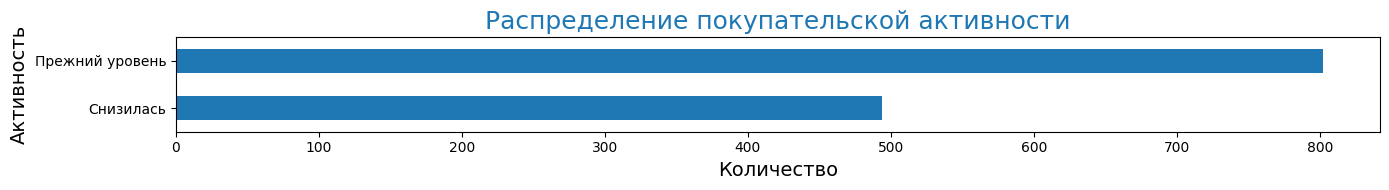

In [22]:
show_barh(
    market_file["покупательская_активность"],
    "Распределение покупательской активности", "Активность"
)

По целевому параметру имеется небольшой дисбаланс в данных - пользователей со снизившейся активностью почти на половину меньше, чем пользователей с прежним уровнем активности. Соответственно метрика Accuracy не очень хорошо подходит для таких даннных.

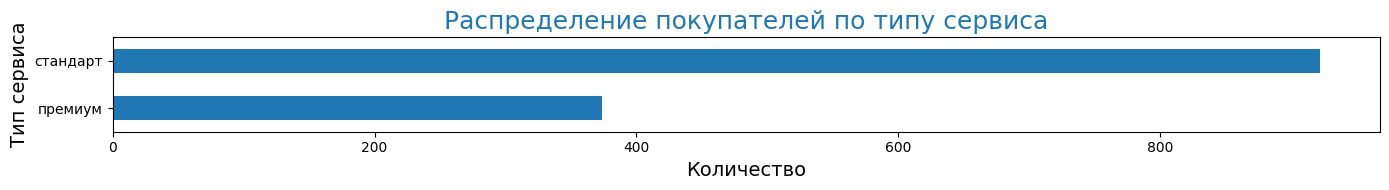

In [23]:
show_barh(
    market_file["тип_сервиса"],
    "Распределение покупателей по типу сервиса", "Тип сервиса"
)

Также имеется дисбаланс по типу сервиса, основная масса пользователей имеют тип сервиса 'стандарт', пользователей с типом сервиса 'премиум' менее 30%.

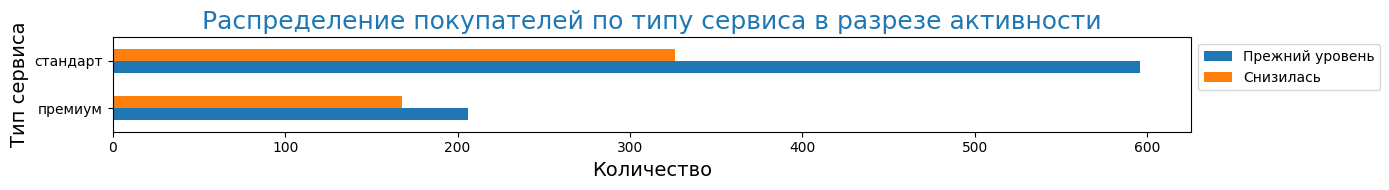

In [24]:
show_barh(
    market_file.pivot_table(
        index="тип_сервиса", columns="покупательская_активность",
        values="id", aggfunc="count"
    ),
    "Распределение покупателей по типу сервиса в разрезе активности", "Тип сервиса"
)

Заметно, что очень сильное снижение активности у премиум подписчиков. У более 45% таких подписчиков отмечено снижение активности. У пользователей со стандартной подпиской снижение активности менее выражено.

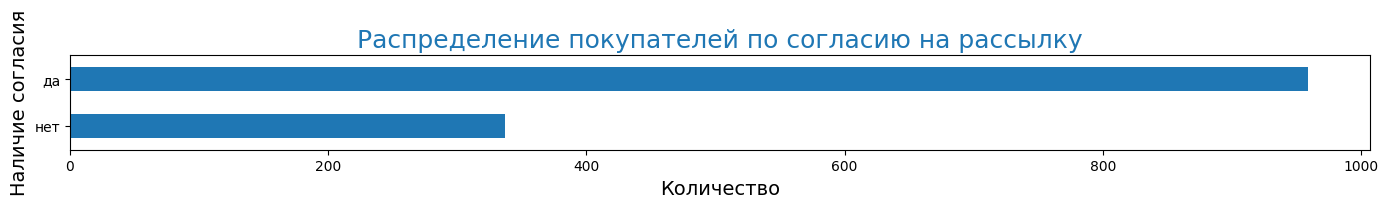

In [25]:
show_barh(
    market_file["разрешить_сообщать"],
    "Распределение покупателей по согласию на рассылку", "Наличие согласия"
)

Большая часть пользователей выразило согласие на получение рассылки.

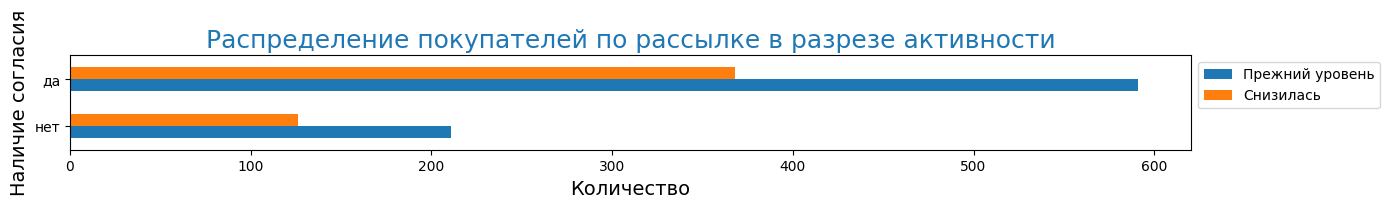

In [26]:
show_barh(
    market_file.pivot_table(
        index="разрешить_сообщать", columns="покупательская_активность",
        values="id", aggfunc="count"
    ),
    "Распределение покупателей по рассылке в разрезе активности", "Наличие согласия"
)

Соотношение пользователей по наличию согласия на получение рассылки в разрезе активности близкое, независимо от их пользовательской активности.

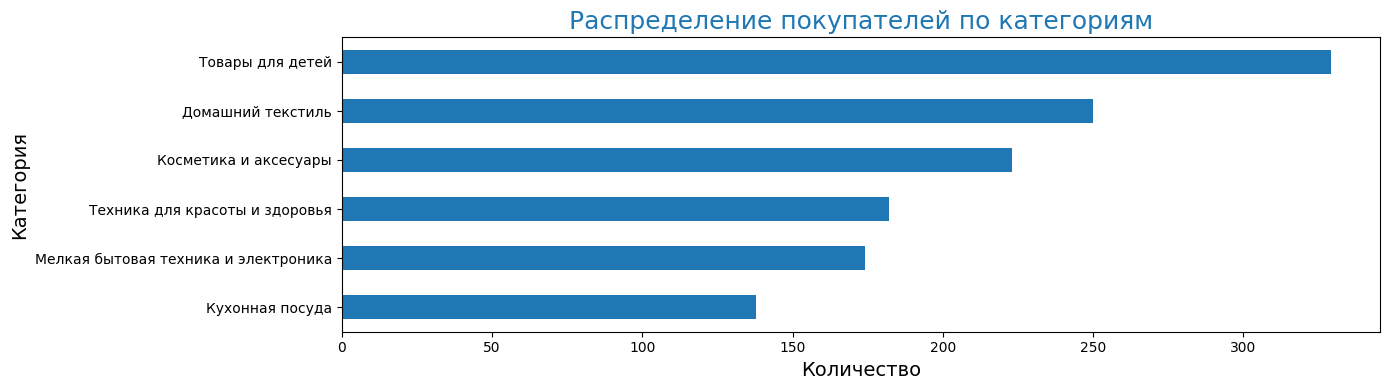

In [27]:
show_barh(
    market_file["популярная_категория"],
    "Распределение покупателей по категориям", "Категория",
    figsize=(14, 4)
)

Самые популярные категории у пользователей - 'Товары для детей', 'Домашний текстиль' и 'Косметика и акссесуары'. Наименее популярные - 'Кухонная посуда', 'Мелкая бытовая техника и электроника', а также 'Техника для красоты и здоровья'.

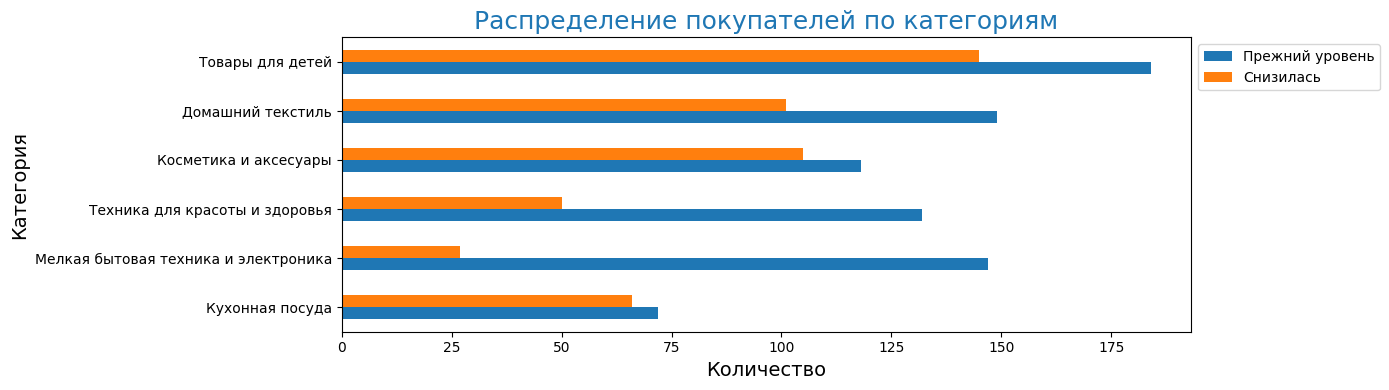

In [28]:
show_barh(
    market_file.pivot_table(
        index="популярная_категория", columns="покупательская_активность",
        values="id", aggfunc="count"
    ),
    "Распределение покупателей по категориям", "Категория",
    figsize=(14, 4)
)

Наибольшее снижение покупательской активности заметно для пользователей со следующими популярными категориями - 'Кухонная посуда', 'Косметика и аксесуары', а также 'Товары для детей'. Наименьшее снижение активности по категории 'Мелкая бытовая техника и электроника' и 'Техника для красоты и здоровья'.

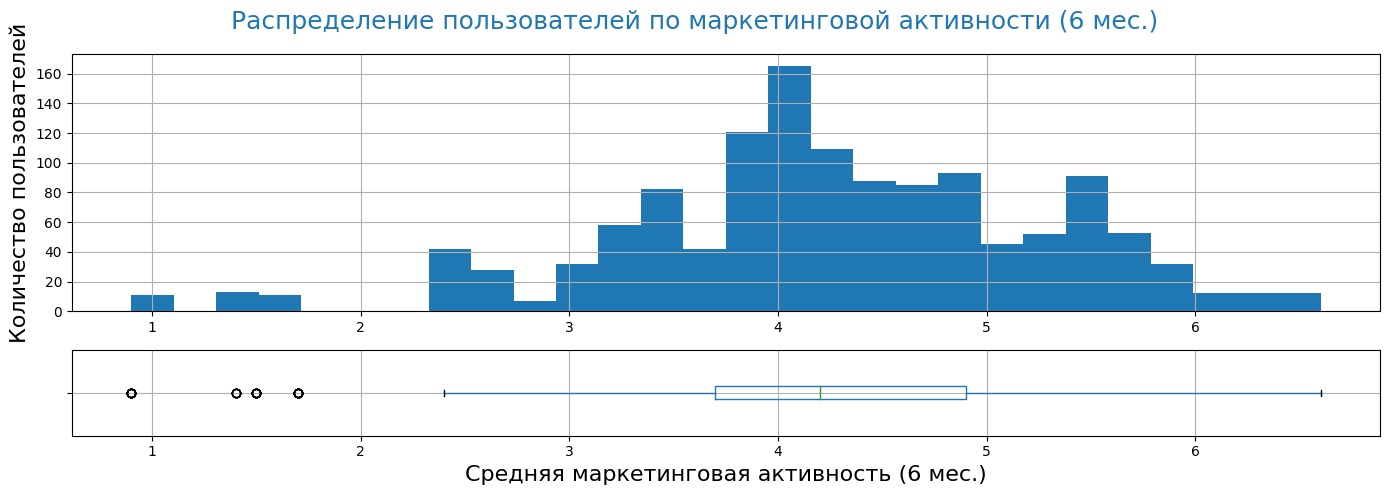

count      mean       std  min  \
Средняя маркетинговая активность (6 мес.)  1296.0  4.256404  1.013525  0.9   

                                           25%  50%  75%  max      Gaussian  \
Средняя маркетинговая активность (6 мес.)  3.7  4.2  4.9  6.6  Probably NOT   

                                                p_value  
Средняя маркетинговая активность (6 мес.)  3.785868e-13

In [29]:
show_hist(
    market_file["маркет_актив_6_мес"],
    "Распределение пользователей по маркетинговой активности (6 мес.)", 
    "Средняя маркетинговая активность (6 мес.)", "Количество пользователей", 
    bins=28, figsize=(14, 5), boxplot=True
)

Средняя маркетинговая активность за полугодие для основной массы пользователей составляет от 3-х до более 6-ти мероприятий, однако имеются пользователи, по которым маркетинговые мероприятия проводились в среднем менее 2-х раз.

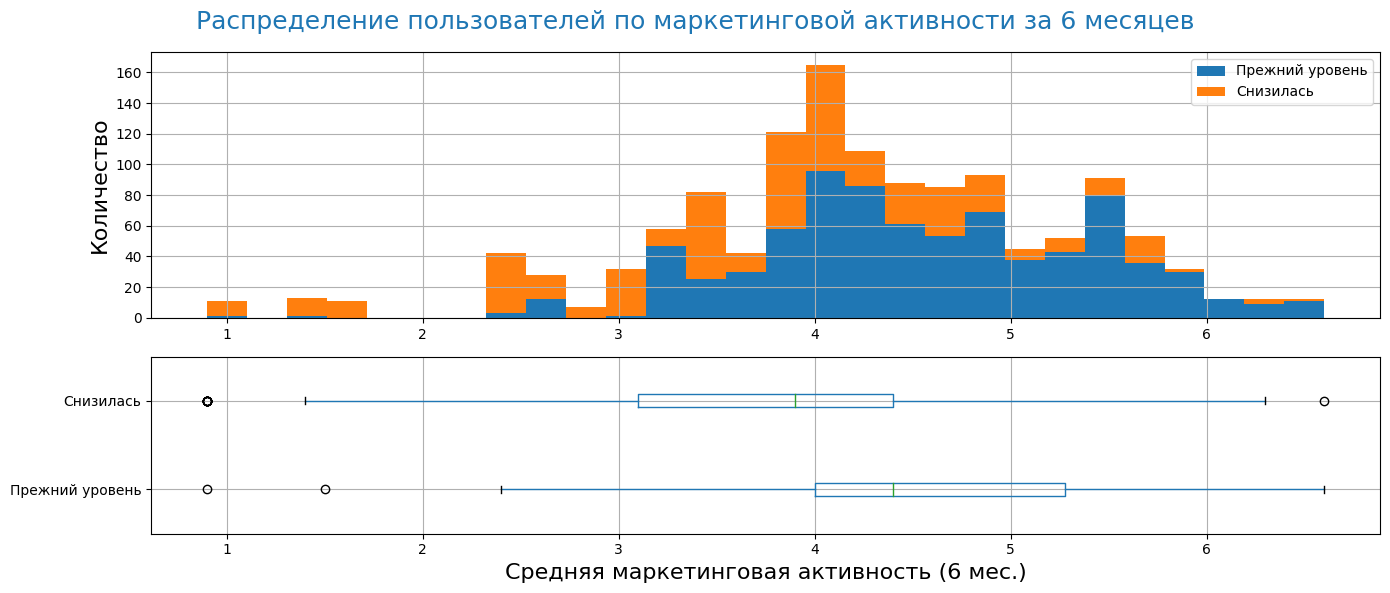

count      mean       std  min  25%  50%    75%  \
Покупательская активность                                                    
Прежний уровень            802.0  4.570075  0.848618  0.9  4.0  4.4  5.275   
Снизилась                  494.0  3.747166  1.052777  0.9  3.1  3.9  4.400   

                           max      Gaussian       p_value  
Покупательская активность                                   
Прежний уровень            6.6  Probably NOT  2.698477e-07  
Снизилась                  6.6  Probably NOT  1.749832e-07

In [30]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="маркет_актив_6_мес"
    ),
    "Распределение пользователей по маркетинговой активности за 6 месяцев",
    "Средняя маркетинговая активность (6 мес.)",
    columns="Покупательская активность", bins=28
)

В разрезе покупательской активности заметно, что большее соотношение пользователей со снизившейся покупательской активностью приходится на тех, у которых меньше средняя маркетинговая активность.

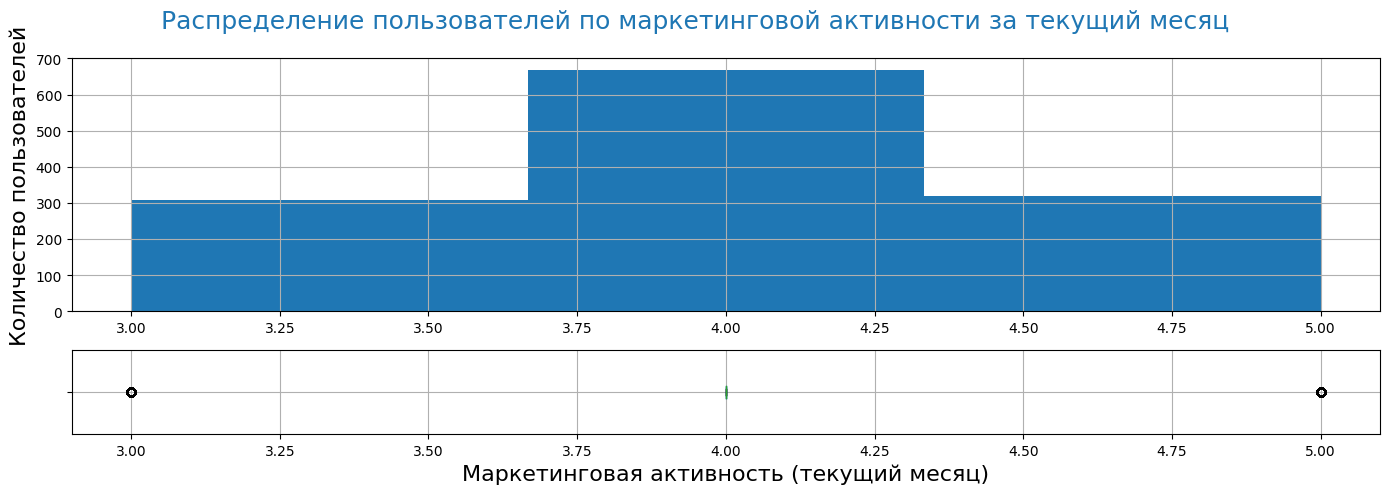

count      mean       std  min  \
Маркетинговая активность (текущий месяц)  1296.0  4.009259  0.696316  3.0   

                                          25%  50%  75%  max      Gaussian  \
Маркетинговая активность (текущий месяц)  4.0  4.0  4.0  5.0  Probably NOT   

                                               p_value  
Маркетинговая активность (текущий месяц)  8.104835e-37

In [31]:
show_hist(
    market_file["маркет_актив_тек_мес"], 
    "Распределение пользователей по маркетинговой активности за текущий месяц", 
    "Маркетинговая активность (текущий месяц)", "Количество пользователей", 
    bins=3, figsize=(14, 5), boxplot=True
)

По текущему месяцу заметно, что отсутствуют пользователи без маркетинговой активности. Более половины пользователей получило 4 маркетинговых коммуникации в текущем месяце, остальные получили по 3 или 5 активностей. Это говорит о том, что в текущем месяце активизировались маркетинговые коммуникации.

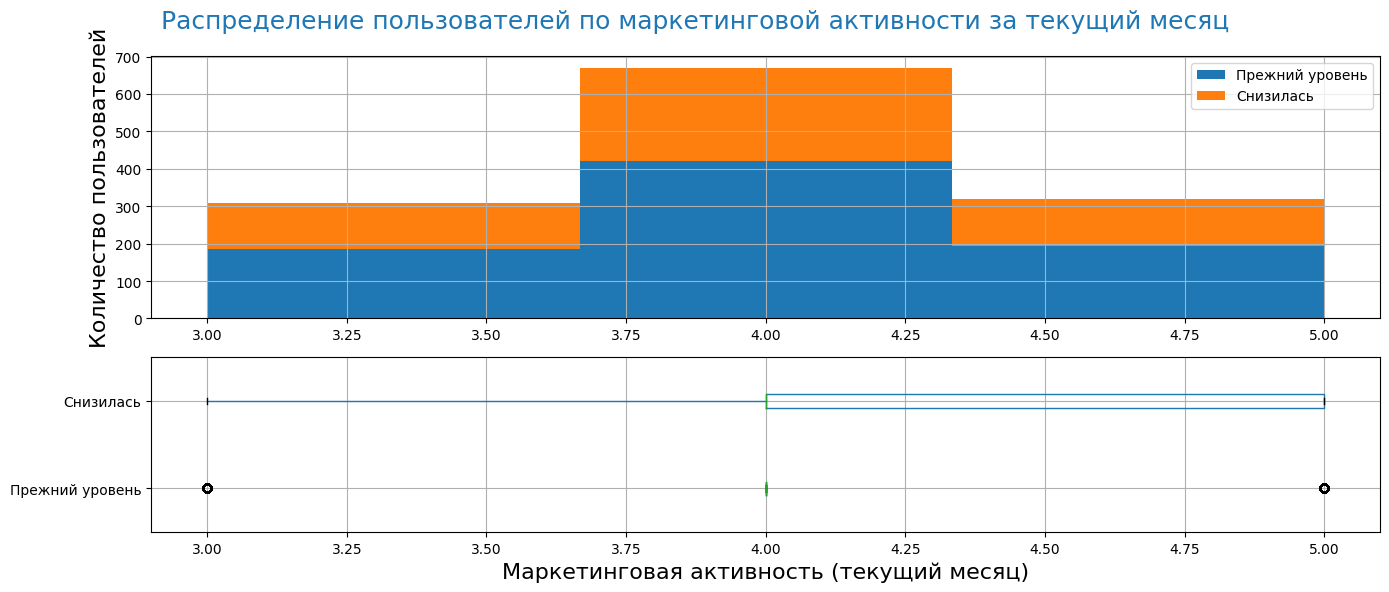

count      mean       std  min  25%  50%  75%  max  \
Покупательская активность                                                       
Прежний уровень            802.0  4.011222  0.689586  3.0  4.0  4.0  4.0  5.0   
Снизилась                  494.0  4.006073  0.707797  3.0  4.0  4.0  5.0  5.0   

                               Gaussian       p_value  
Покупательская активность                              
Прежний уровень            Probably NOT  5.030570e-30  
Снизилась                  Probably NOT  8.239937e-24

In [32]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="маркет_актив_тек_мес"
    ), 
    "Распределение пользователей по маркетинговой активности за текущий месяц", 
    "Маркетинговая активность (текущий месяц)", "Количество пользователей", 
    columns="Покупательская активность", bins=3
)

В разрезе изменения пользовательской активности можно отметить, что распределение достаточно равномерное.

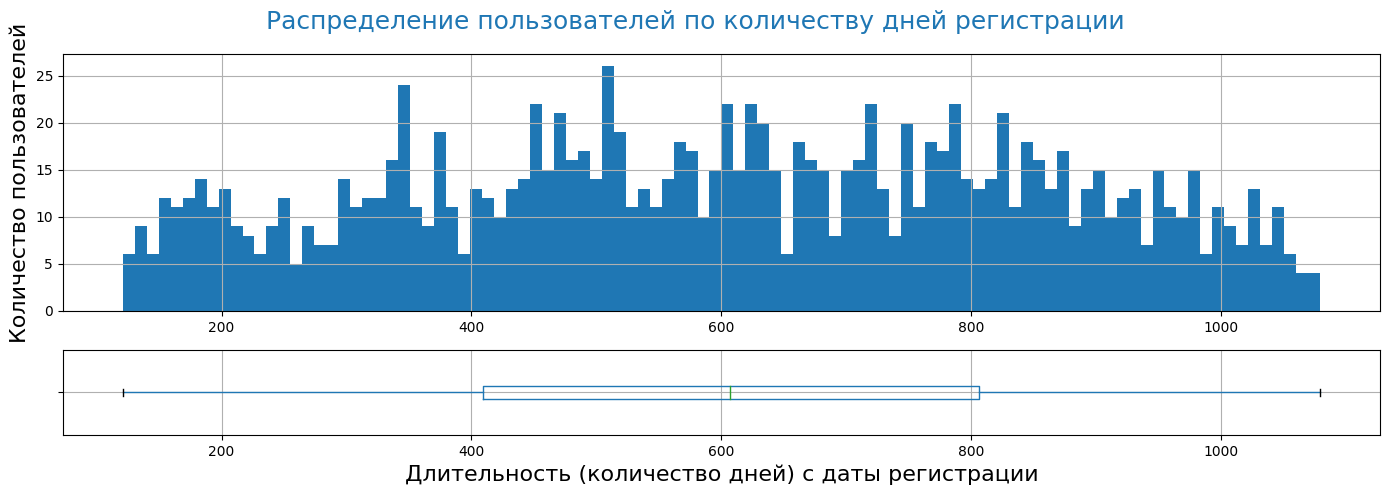

count        mean  \
Длительность (количество дней) с даты регистрации  1296.0  602.967593   

                                                          std    min    25%  \
Длительность (количество дней) с даты регистрации  249.195823  121.0  409.5   

                                                     50%     75%     max  \
Длительность (количество дней) с даты регистрации  606.5  806.25  1079.0   

                                                       Gaussian       p_value  
Длительность (количество дней) с даты регистрации  Probably NOT  5.746412e-15

In [33]:
show_hist(
    market_file["длительность"], 
    "Распределение пользователей по количеству дней регистрации", 
    "Длительность (количество дней) с даты регистрации", "Количество пользователей", 
    bins=100, figsize=(14, 5), boxplot=True
)

По срокам регистрации пользователей в магазине распределение достаточно равномерное, имеются пользователи до 3-х лет на сайте. Основная масса пользователей зарегистрированы от 400 до 800 дней.

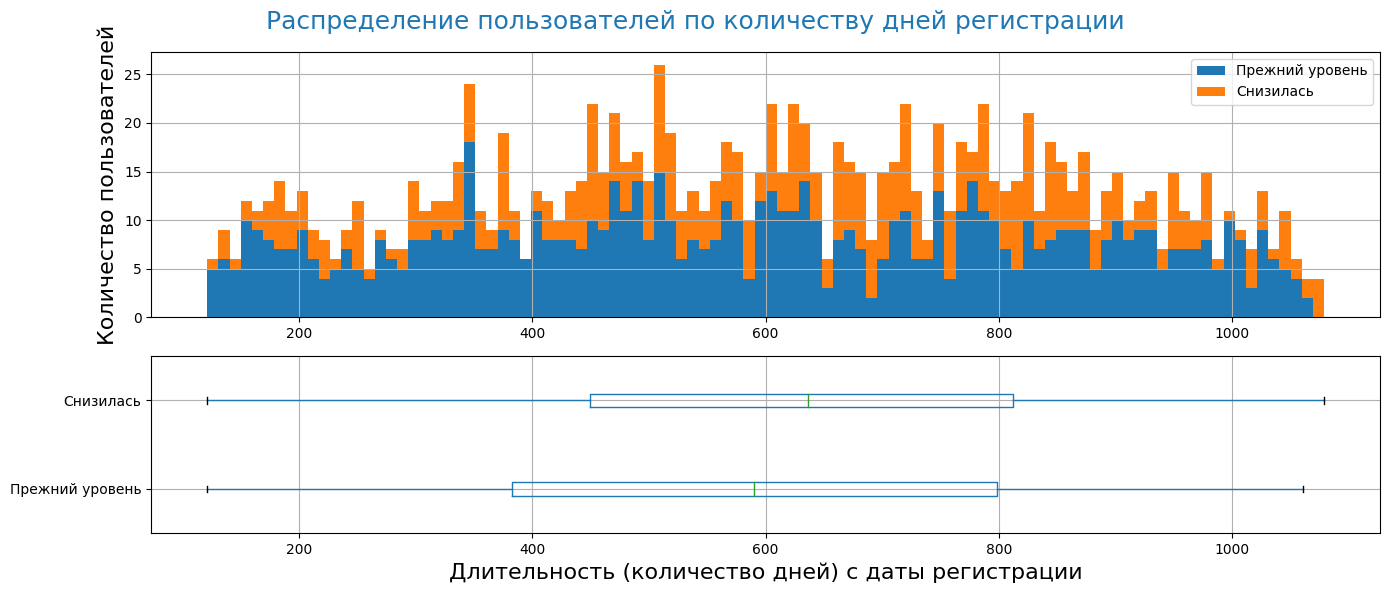

count        mean         std    min    25%    50%  \
Покупательская активность                                                       
Прежний уровень            802.0  590.730673  255.330179  121.0  382.5  590.0   
Снизилась                  494.0  622.834008  237.817052  121.0  449.0  636.5   

                              75%     max      Gaussian       p_value  
Покупательская активность                                              
Прежний уровень            798.75  1061.0  Probably NOT  1.817037e-12  
Снизилась                  812.50  1079.0  Probably NOT  1.026567e-06

In [34]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="длительность"
    ), 
    "Распределение пользователей по количеству дней регистрации", 
    "Длительность (количество дней) с даты регистрации", "Количество пользователей", 
    columns="Покупательская активность", bins=100
)

По изменению активности распределение также достаточно равномерное, явных перекосов не наблюдается.

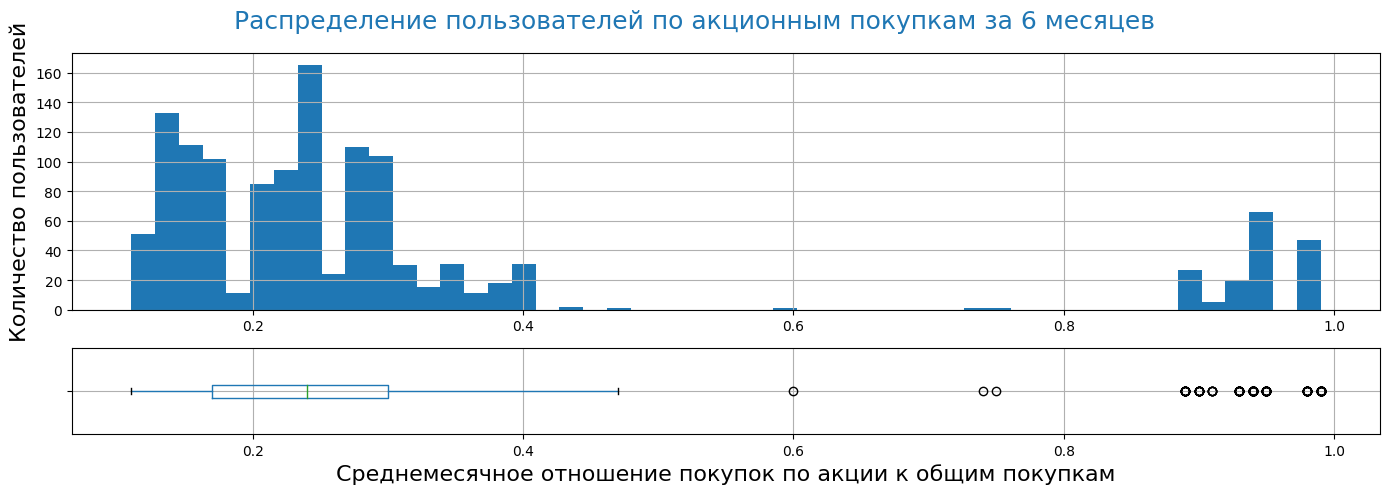

count      mean  \
Среднемесячное отношение покупок по акции к общ...  1296.0  0.320069   

                                                         std   min   25%  \
Среднемесячное отношение покупок по акции к общ...  0.249159  0.11  0.17   

                                                     50%  75%   max  \
Среднемесячное отношение покупок по акции к общ...  0.24  0.3  0.99   

                                                        Gaussian       p_value  
Среднемесячное отношение покупок по акции к общ...  Probably NOT  4.203895e-45

In [35]:
show_hist(
    market_file["акционные_покупки"], 
    "Распределение пользователей по акционным покупкам за 6 месяцев", 
    "Среднемесячное отношение покупок по акции к общим покупкам", "Количество пользователей", 
    bins=50, figsize=(14, 5), boxplot=True
)

По акционным покупкам заметно разделение на две большие группы. Основная масса пользователей осуществляет акционные покупки от 11% до 50% от всех покупок. Однако имеется достаточно большая группа пользователей, у которых высокое соотношение акционных закупок, в том числе более 80%.

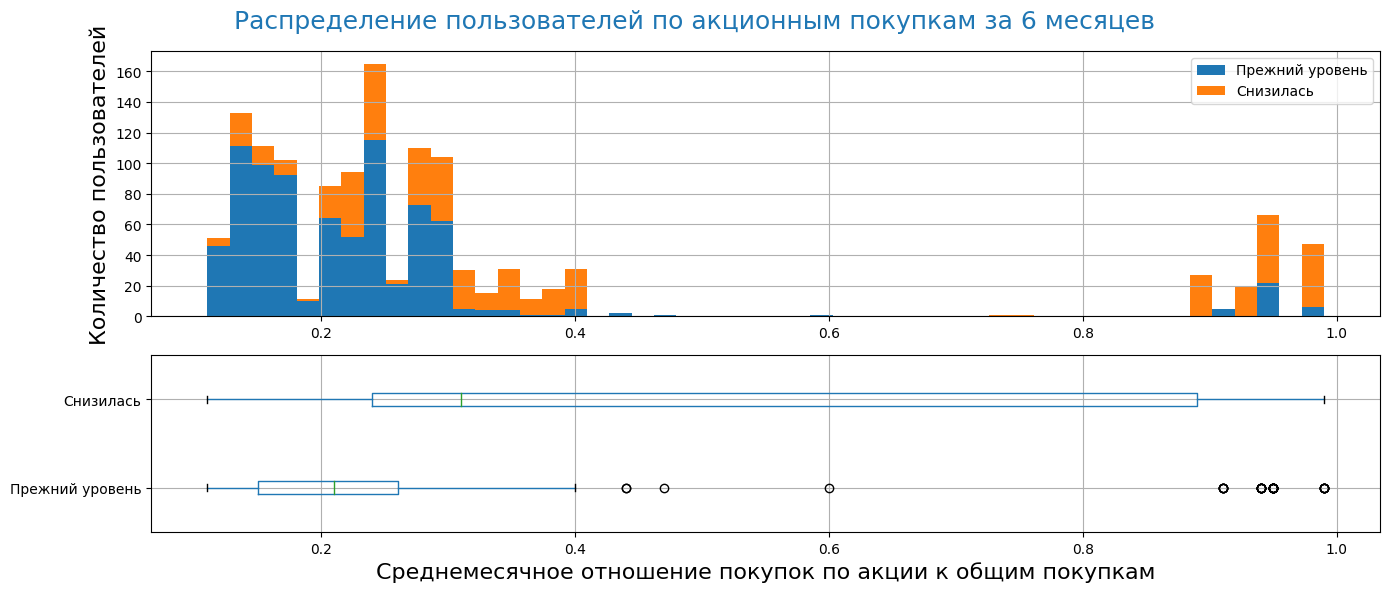

count      mean       std   min   25%   50%   75%  \
Покупательская активность                                                      
Прежний уровень            802.0  0.238367  0.160599  0.11  0.15  0.21  0.26   
Снизилась                  494.0  0.452713  0.304428  0.11  0.24  0.31  0.89   

                            max      Gaussian       p_value  
Покупательская активность                                    
Прежний уровень            0.99  Probably NOT  7.862686e-41  
Снизилась                  0.99  Probably NOT  1.343363e-26

In [36]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="акционные_покупки"
    ), 
    "Распределение пользователей по акционным покупкам за 6 месяцев", 
    "Среднемесячное отношение покупок по акции к общим покупкам", "Количество пользователей", 
    columns="Покупательская активность", bins=50
)

В разрезе пользовательской активности можно отметить, что соотношение пользователей активность которых снизилась выше для тех, которые чаще делают акционные покупки.

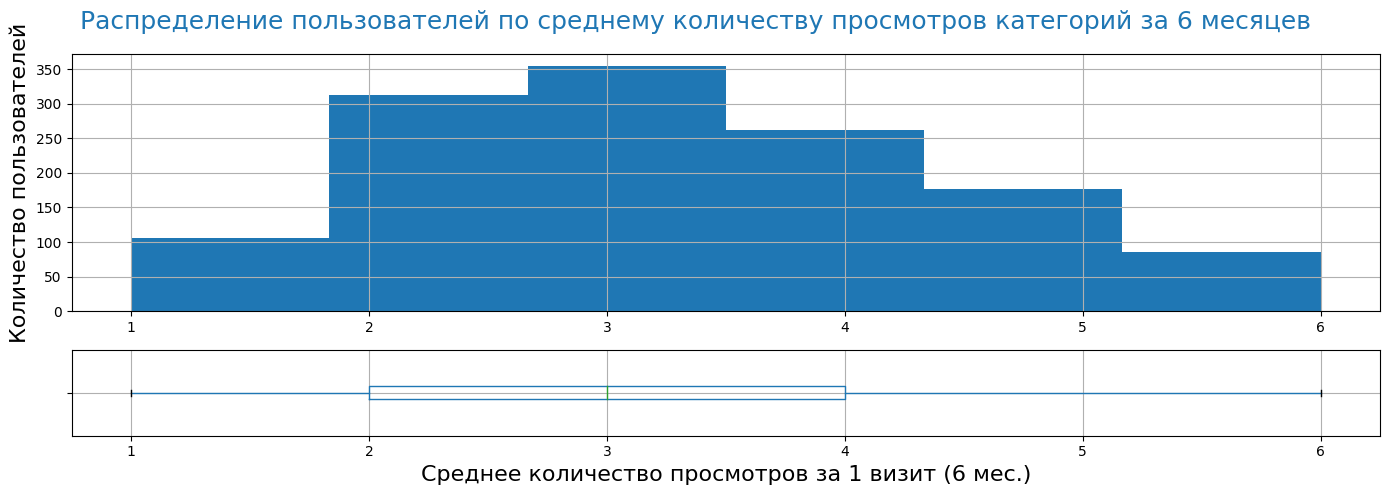

count      mean       std  \
Среднее количество просмотров за 1 визит (6 мес.)  1296.0  3.267747  1.355125   

                                                   min  25%  50%  75%  max  \
Среднее количество просмотров за 1 визит (6 мес.)  1.0  2.0  3.0  4.0  6.0   

                                                       Gaussian       p_value  
Среднее количество просмотров за 1 визит (6 мес.)  Probably NOT  4.676106e-24

In [37]:
show_hist(
    market_file["средний_просмотр_категорий_за_визит"], 
    "Распределение пользователей по среднему количеству просмотров категорий за 6 месяцев", 
    "Среднее количество просмотров за 1 визит (6 мес.)", "Количество пользователей", 
    bins=6, figsize=(14, 5), boxplot=True
)

По среднему количеству просмотров категорий, основная масса пользователей просматривает в среднем от 2-х до 4-ти категорий. График похож на распределение Пуассона.

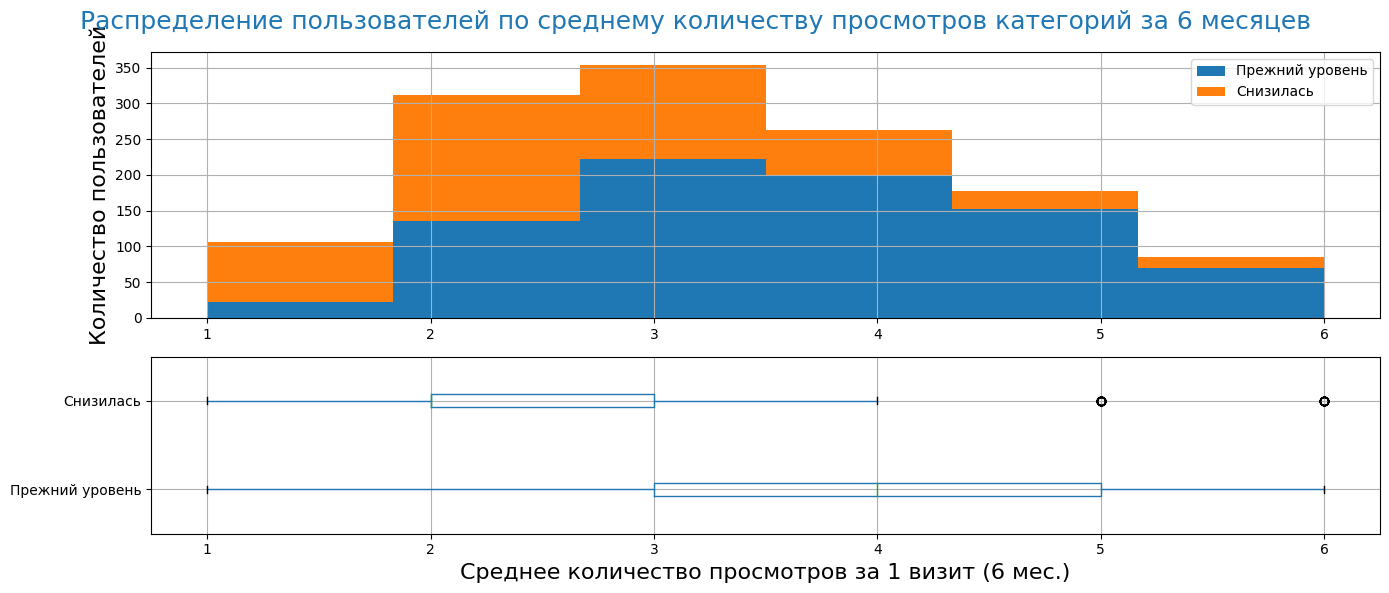

count      mean       std  min  25%  50%  75%  max  \
Покупательская активность                                                       
Прежний уровень            802.0  3.665835  1.277112  1.0  3.0  4.0  5.0  6.0   
Снизилась                  494.0  2.621457  1.223678  1.0  2.0  2.0  3.0  6.0   

                               Gaussian       p_value  
Покупательская активность                              
Прежний уровень            Probably NOT  1.197241e-18  
Снизилась                  Probably NOT  4.514248e-18

In [38]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="средний_просмотр_категорий_за_визит"
    ), 
    "Распределение пользователей по среднему количеству просмотров категорий за 6 месяцев", 
    "Среднее количество просмотров за 1 визит (6 мес.)", "Количество пользователей", 
    columns="Покупательская активность", bins=6
)

Снижение активности наблюдается больше для пользователей, которые просматривают в среднем меньше категорий за визит. Скорее всего по данному параметру имеется довольно высокая корреляция с целевым.

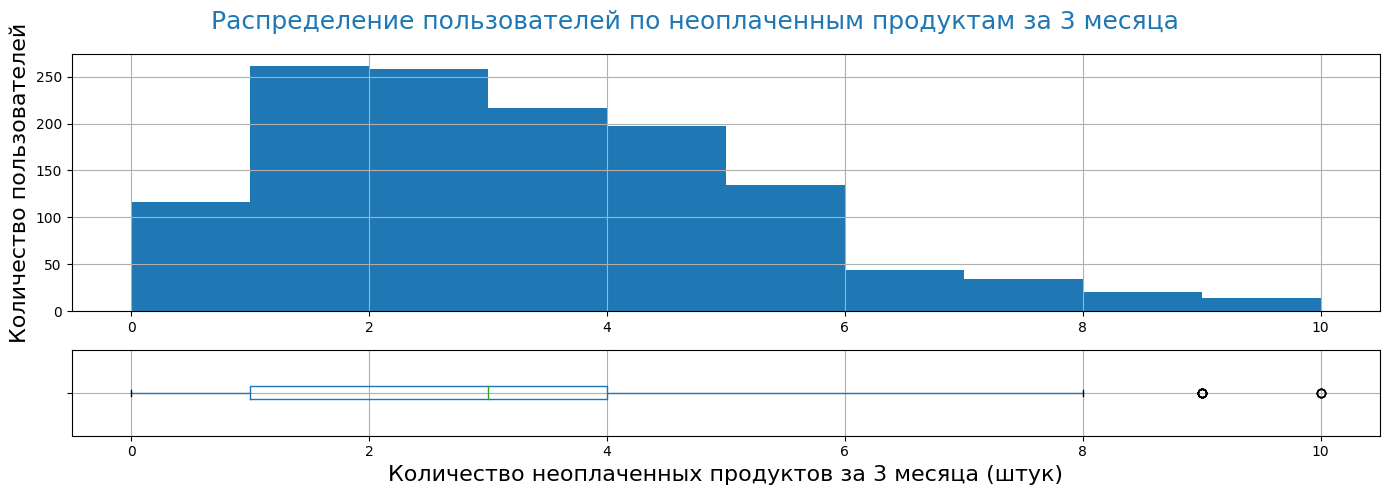

count      mean  \
Количество неоплаченных продуктов за 3 месяца (...  1296.0  2.841821   

                                                         std  min  25%  50%  \
Количество неоплаченных продуктов за 3 месяца (...  1.974074  0.0  1.0  3.0   

                                                    75%   max      Gaussian  \
Количество неоплаченных продуктов за 3 месяца (...  4.0  10.0  Probably NOT   

                                                         p_value  
Количество неоплаченных продуктов за 3 месяца (...  1.163481e-23

In [39]:
show_hist(
    market_file["неоплаченные_продукты_штук_квартал"], 
    "Распределение пользователей по неоплаченным продуктам за 3 месяца", 
    "Количество неоплаченных продуктов за 3 месяца (штук)", "Количество пользователей", 
    bins=10, figsize=(14, 5), boxplot=True
)

График данного распределения также похож на распределение Пуассона. Основная масса пользователей имеет от 1-го до 4-х неоплаченных продуктов за последние 3 месяца. Также имеются пользователи, которые не произвели оплату по более 8-ми продуктам.

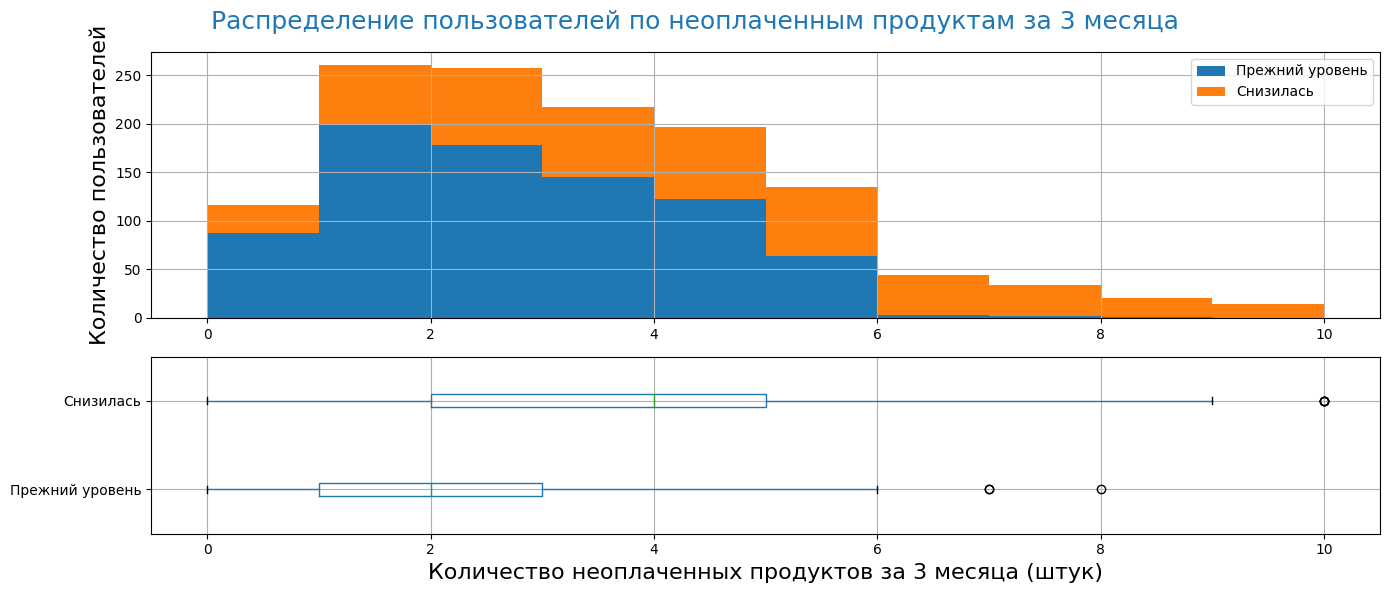

count      mean       std  min  25%  50%  75%  \
Покупательская активность                                                  
Прежний уровень            802.0  2.293017  1.508255  0.0  1.0  2.0  3.0   
Снизилась                  494.0  3.732794  2.292385  0.0  2.0  4.0  5.0   

                            max      Gaussian       p_value  
Покупательская активность                                    
Прежний уровень             8.0  Probably NOT  1.560315e-18  
Снизилась                  10.0  Probably NOT  2.248474e-10

In [40]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="неоплаченные_продукты_штук_квартал"
    ), 
    "Распределение пользователей по неоплаченным продуктам за 3 месяца", 
    "Количество неоплаченных продуктов за 3 месяца (штук)", "Количество пользователей", 
    columns="Покупательская активность", bins=10
)

В разрезе пользовательской активности, заметно, что снижение активности выше у пользователей по мере увеличения количества неоплаченных продуктов.

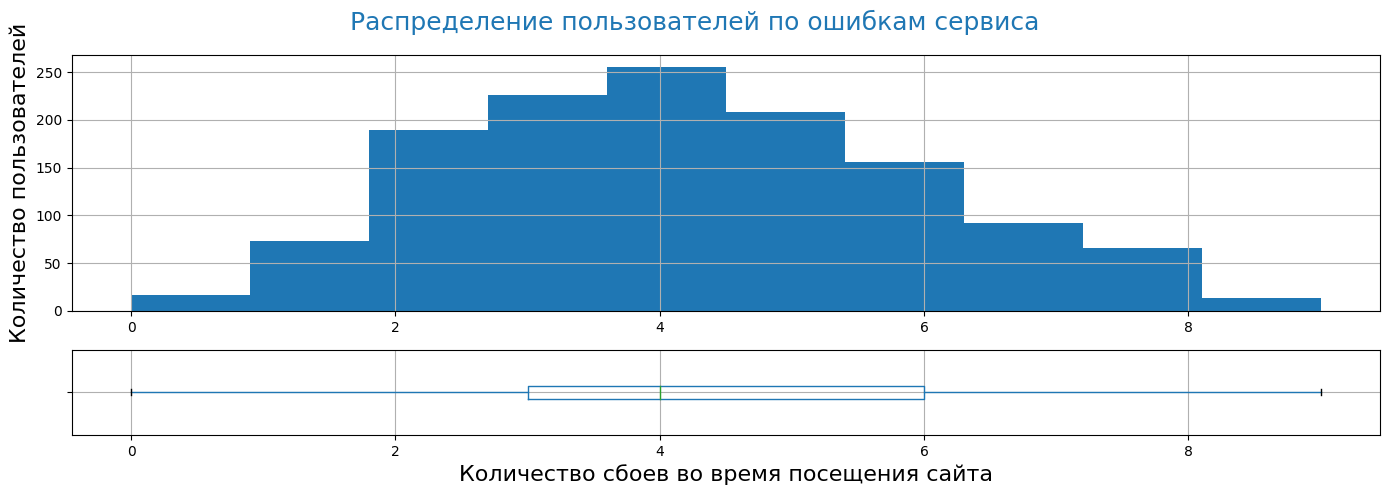

count      mean       std  min  \
Количество сбоев во время посещения сайта  1296.0  4.184414  1.951719  0.0   

                                           25%  50%  75%  max      Gaussian  \
Количество сбоев во время посещения сайта  3.0  4.0  6.0  9.0  Probably NOT   

                                                p_value  
Количество сбоев во время посещения сайта  6.499693e-17

In [41]:
show_hist(
    market_file["ошибка_сервиса"], 
    "Распределение пользователей по ошибкам сервиса", 
    "Количество сбоев во время посещения сайта", "Количество пользователей", 
    bins=10, figsize=(14, 5), boxplot=True
)

По ошибка сервиса можно скзать, что бльшая часть пользователей сталкивались от 3-х до 6-ти сбоям во время посещения сервиса. Максимальное количество сбоев, с которыми столкнулись пользователи составляет 9, а некоторые пользователи вообще не сталкивались с ошибками сервиса.

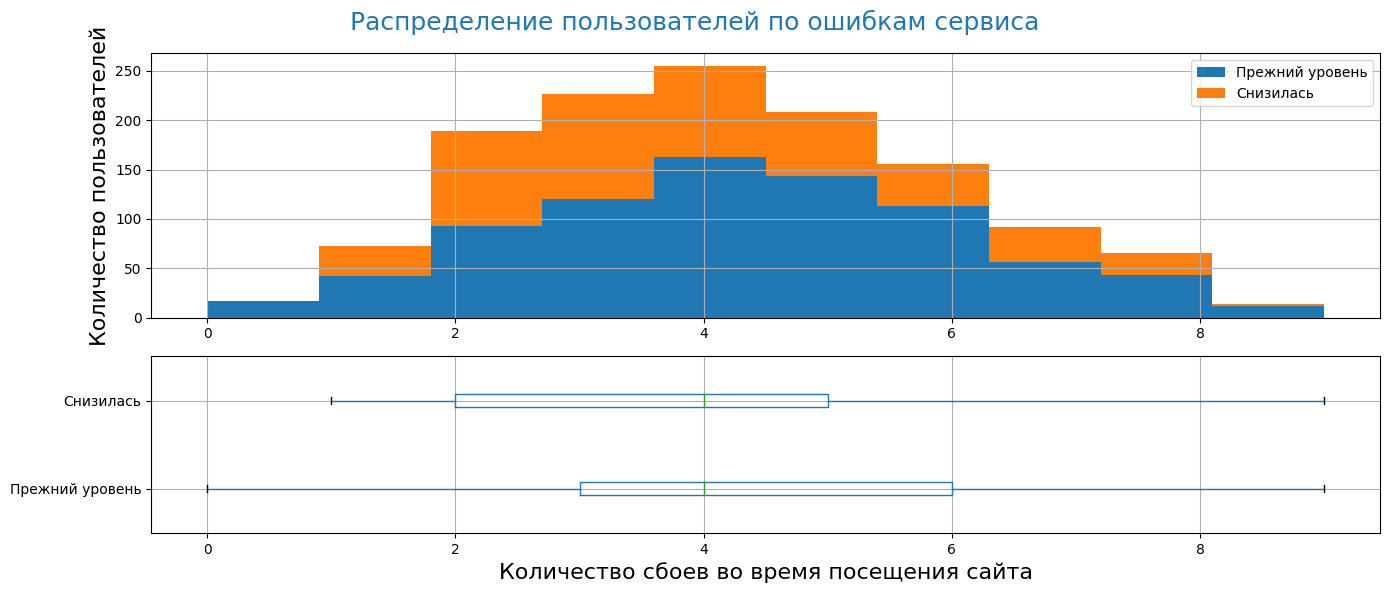

count      mean       std  min  25%  50%  75%  max  \
Покупательская активность                                                       
Прежний уровень            802.0  4.335411  1.979538  0.0  3.0  4.0  6.0  9.0   
Снизилась                  494.0  3.939271  1.882005  1.0  2.0  4.0  5.0  9.0   

                               Gaussian       p_value  
Покупательская активность                              
Прежний уровень            Probably NOT  3.752909e-11  
Снизилась                  Probably NOT  1.296322e-13

In [42]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="ошибка_сервиса"
    ), 
    "Распределение пользователей по ошибкам сервиса", 
    "Количество сбоев во время посещения сайта", "Количество пользователей", 
    columns="Покупательская активность", bins=10
)

Судя по всему количество сбоев сервиса не сильно влияет на снижение пользовательской активности. Перекосы в какую-либо сторону отсутствуют. Соотноошение пользователей со снизившимся уровнем пользовательской активности даже немного снижается по мере увеличения количества сбоев сайта.

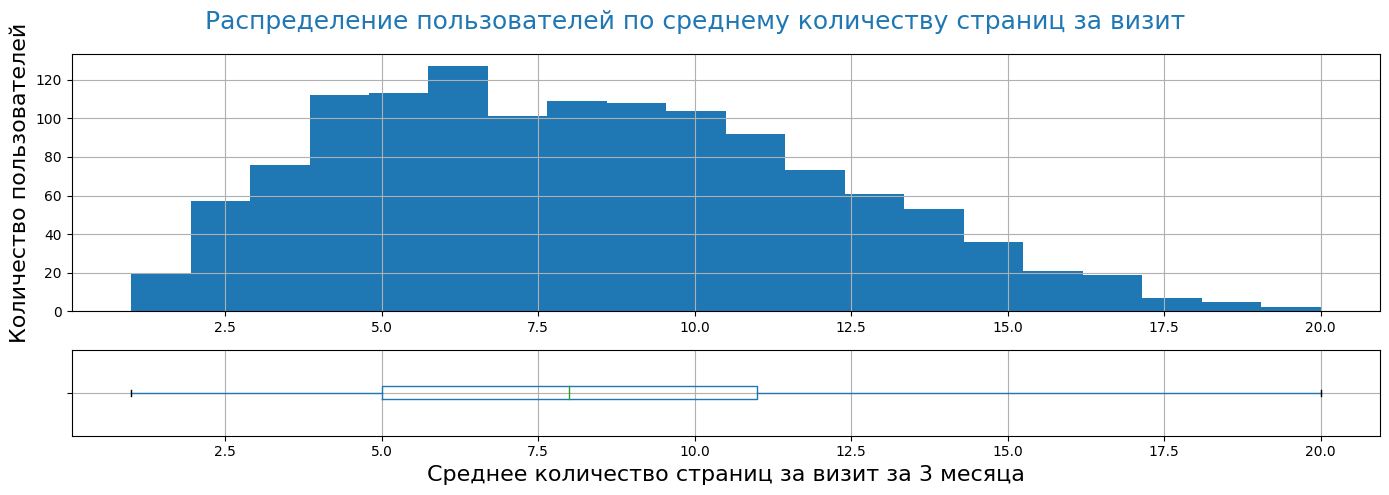

count    mean       std  \
Среднее количество страниц за визит за 3 месяца  1296.0  8.1875  3.978459   

                                                 min  25%  50%   75%   max  \
Среднее количество страниц за визит за 3 месяца  1.0  5.0  8.0  11.0  20.0   

                                                     Gaussian       p_value  
Среднее количество страниц за визит за 3 месяца  Probably NOT  1.544500e-14

In [43]:
show_hist(
    market_file["страниц_за_визит"], 
    "Распределение пользователей по среднему количеству страниц за визит", 
    "Среднее количество страниц за визит за 3 месяца", "Количество пользователей", 
    bins=20, figsize=(14, 5), boxplot=True
)

Пользователи в основном посещают от 5-ти до 11-ти страниц за визит. Заметна небольшая бимодальность в данных.

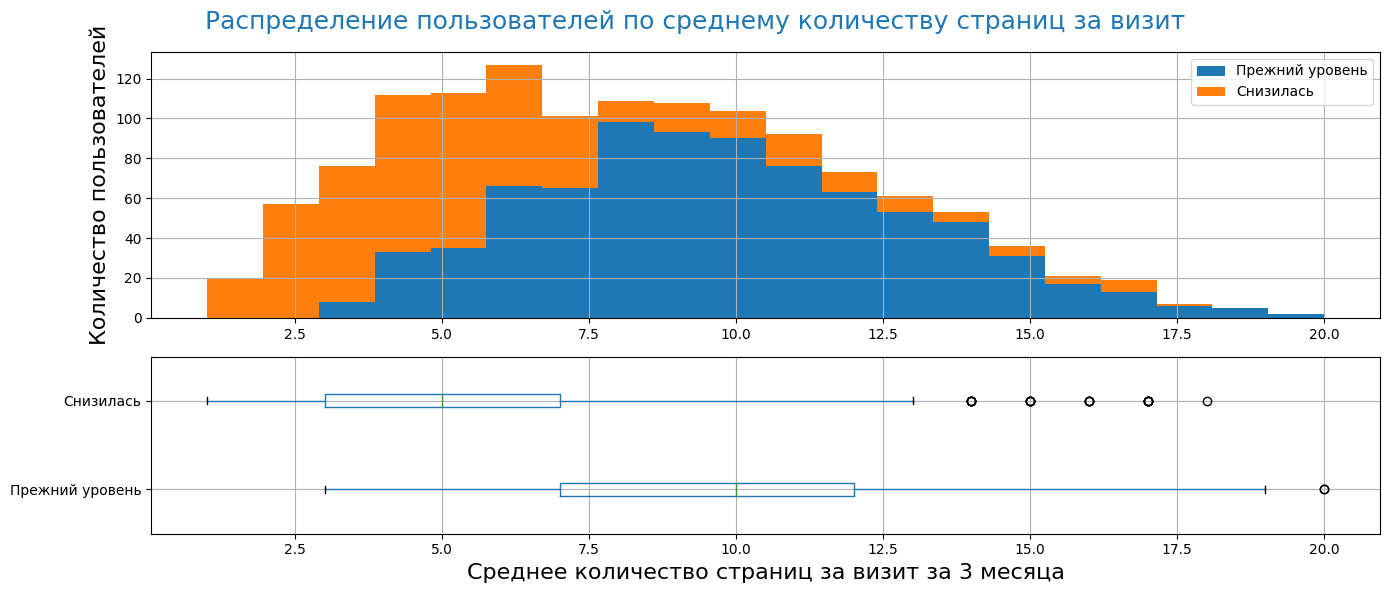

count      mean       std  min  25%   50%   75%  \
Покупательская активность                                                    
Прежний уровень            802.0  9.796758  3.376846  3.0  7.0  10.0  12.0   
Снизилась                  494.0  5.574899  3.463729  1.0  3.0   5.0   7.0   

                            max      Gaussian       p_value  
Покупательская активность                                    
Прежний уровень            20.0  Probably NOT  7.650830e-09  
Снизилась                  18.0  Probably NOT  1.993307e-19

In [44]:
show_hist(
    market_file.pivot(
        columns="покупательская_активность", values="страниц_за_визит"
    ), 
    "Распределение пользователей по среднему количеству страниц за визит", 
    "Среднее количество страниц за визит за 3 месяца", "Количество пользователей", 
    columns="Покупательская активность", bins=20
)

В разрезе пользовательской активности заметно, что снижение преобладает для пользователей с более низким количеством просмотров страниц за визит. Здесь также возможна высокая корреляция с целевым признаком.

### Выручка с покупателя

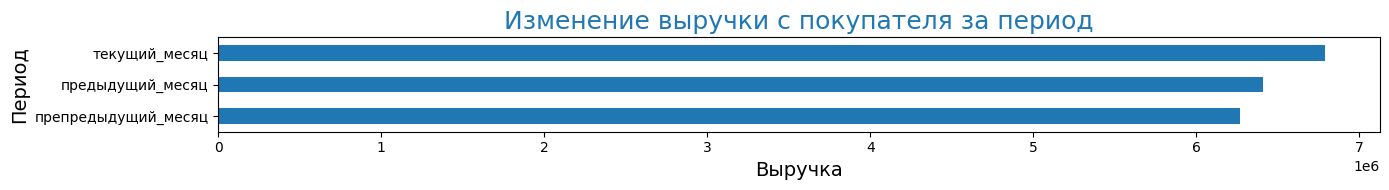

In [45]:
show_barh(
    market_money.pivot_table(
        values="выручка", index="период", aggfunc="sum"
    ).sort_values(by="выручка"),
    "Изменение выручки с покупателя за период", "Период", "Выручка", 
    counts=False
)

Можно отметить рост выручки с покупателей за последние 3 месяца.

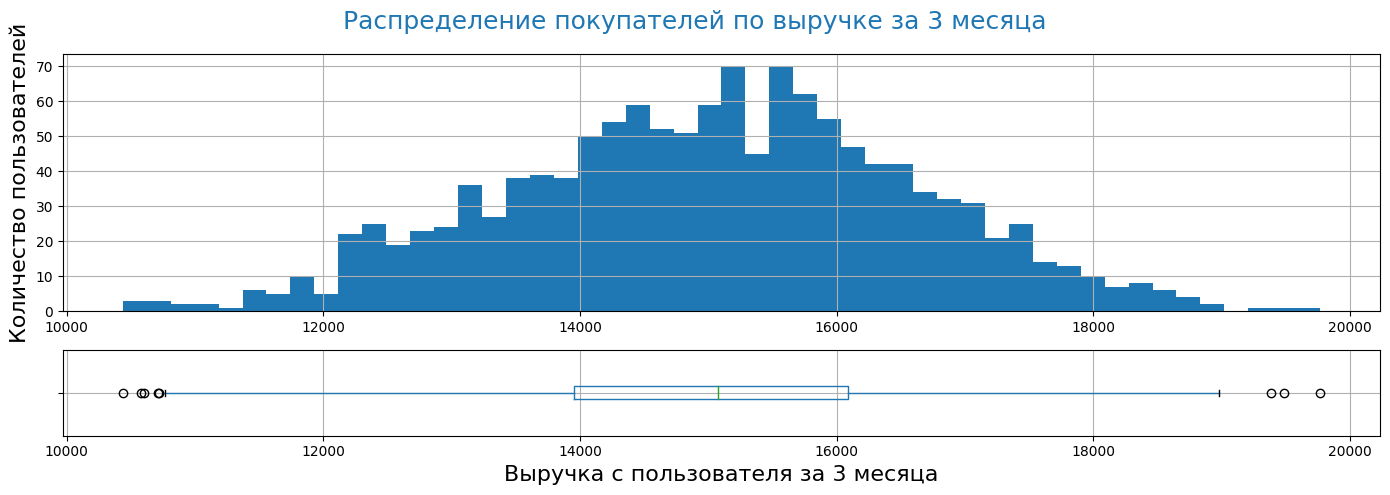

count          mean          std  \
Выручка с пользователя за 3 месяца  1296.0  15021.766975  1581.337135   

                                        min        25%       50%        75%  \
Выручка с пользователя за 3 месяца  10437.6  13954.325  15072.55  16087.025   

                                        max  Gaussian   p_value  
Выручка с пользователя за 3 месяца  19766.5  Probably  0.125695

In [46]:
show_hist(
    market_money.groupby(by="id")["выручка"].sum(), 
    "Распределение покупателей по выручке за 3 месяца", 
    "Выручка с пользователя за 3 месяца", "Количество пользователей", 
    bins=50, figsize=(14, 5), boxplot=True
)

Основная масса покупателей приобрели товар на общую сумму в пределах от 14 до 16 тысяч, самые высокие продажи не доходят до 20 тысяч. Распределение вероятнее всего нормальное.

### Время на сайте

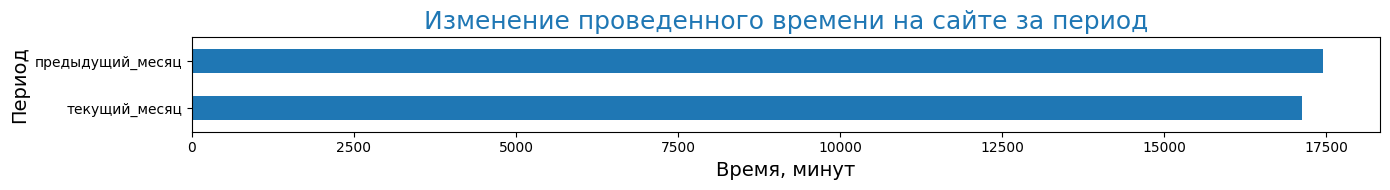

In [47]:
market_time
show_barh(
    market_time.pivot_table(
        values="минут", index="период", aggfunc="sum"
    ).sort_values(by="минут"),
    "Изменение проведенного времени на сайте за период", "Период", 
    "Время, минут", counts=False
)

По проведенному на сайте времени можно отметить, что в текущем месяце заметно снижение.

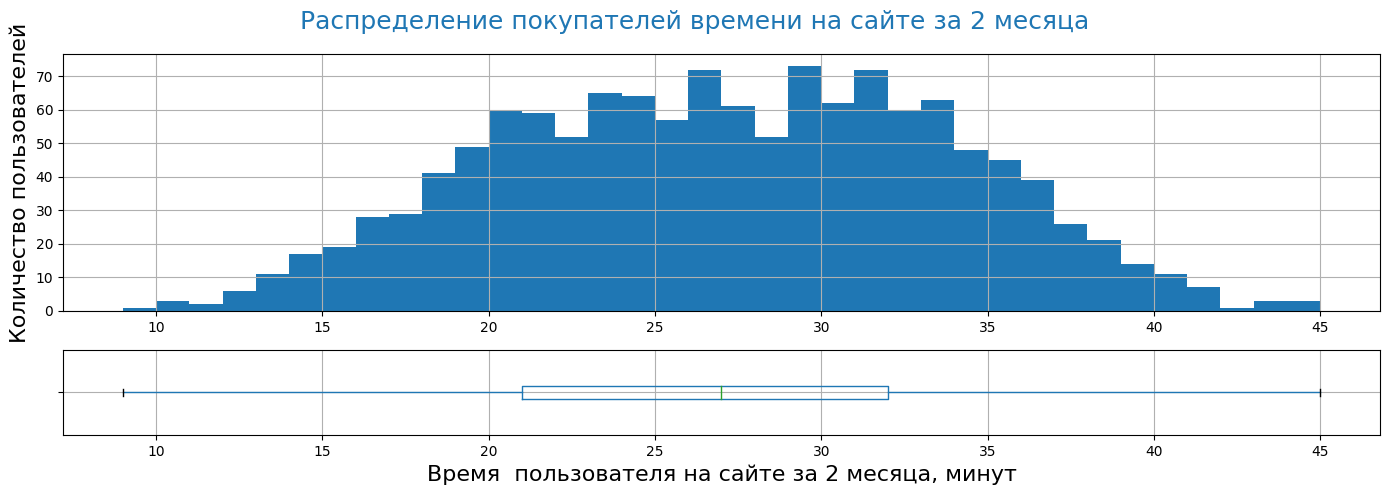

count       mean       std  \
Время  пользователя на сайте за 2 месяца, минут  1296.0  26.681327  6.704311   

                                                 min   25%   50%   75%   max  \
Время  пользователя на сайте за 2 месяца, минут  9.0  21.0  27.0  32.0  45.0   

                                                     Gaussian       p_value  
Время  пользователя на сайте за 2 месяца, минут  Probably NOT  1.313016e-07

In [48]:
show_hist(
    market_time.groupby(by="id")["минут"].sum(), 
    "Распределение покупателей времени на сайте за 2 месяца", 
    "Время  пользователя на сайте за 2 месяца, минут", "Количество пользователей", 
    bins=36, figsize=(14, 5), boxplot=True
)

За последние 2 месяца пользователи провели на сайте от 9 до 45 минут, у основной массы на это уходит от 21 до 32 минут.

### Среднемесячная прибыль

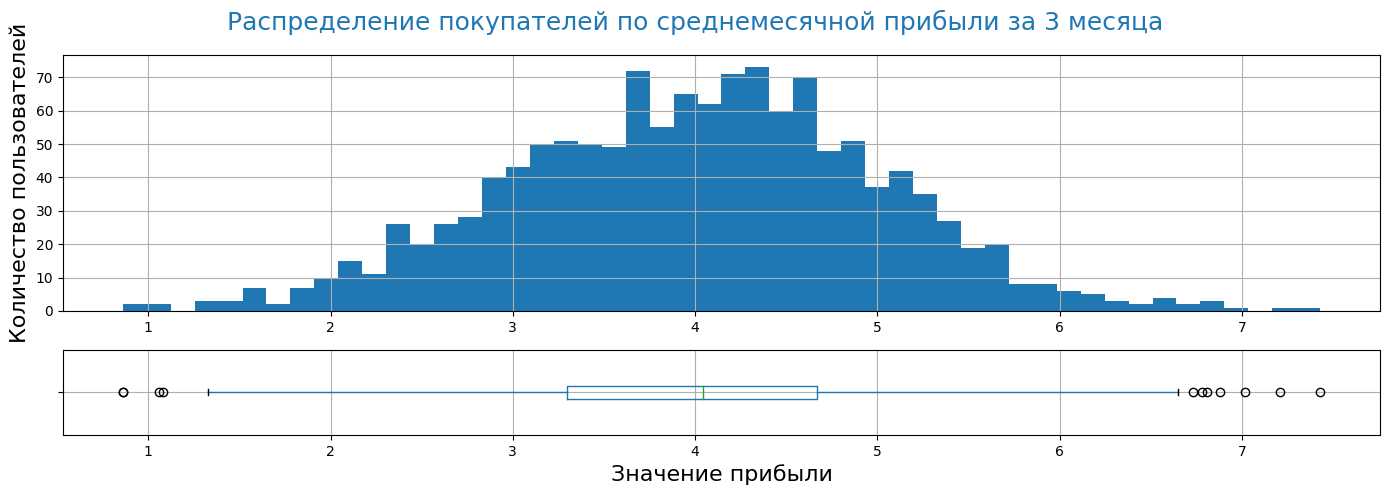

count      mean       std   min  25%    50%   75%   max  \
Значение прибыли  1296.0  3.997701  1.011198  0.86  3.3  4.045  4.67  7.43   

                  Gaussian   p_value  
Значение прибыли  Probably  0.345655

In [49]:
show_hist(
    money["прибыль"], 
    "Распределение покупателей по среднемесячной прибыли за 3 месяца", 
    "Значение прибыли", "Количество пользователей", 
    bins=50, figsize=(14, 5), boxplot=True
)

По распределению покупателей в зависимости от среднемесячной прибыли за последние 3 месяца можно отметить, что основная масса покупателей приносит среднемесячную прибыль в пределах от 3.3 до 4.67. Распределение вероятнее всего нормальное.

### Промежуточные выводы

Пользователи, покупательская активность которых составляет менее 3-х месяцев были исключены из выборки, в том числе пользователь с аномально высоким значением выручки.

Проведен исследовательский анализ данных, по результатам которого можно отметить следующее:
1. По целевому признаку имеется дисбаланс данных, пользователей со снизившейся активностью почти на половину меньше чем пользователей с прежним уровнем активности.
2. Заметно высокое отношение покупателей со снизившейся активностью у премиум подписчиков.
3. По популярным категориям имеются большие расхождения по соотношению пользователей в разрезе пользовательской активности - самое низкое соотношение пользователей со снизившейся активностью в категориях 'Мелкая бытовая техника и электроника' и 'Техника для красоты и здоровья', самое высокое соотношение - 'Кухонная посуда', 'Косметика и аксесуары' и 'Товары для детей'.
4. Можно также отметить о вероятной зависимости целевого признака пользовательской активности со следующими признаками:
    - маркетинговая активность за 6 месяцев, чем она выше, тем ниже отношение пользователей со снизившейся активностью;
    - отношение покупок по акции - чем больше таких покупок, тем выше пользователей со снизившеся активностью;
    - среднее количество просмотров категорий за визит - чем больше просмотров, тем ниже отношение пользователей со снизившейся активностью;
    - количество неоплаченных продуктов - чем больше продуктов, тем выше отношение пользователей со снизившейся активностью;
    - среднее количество страниц за визит - чем больше страниц, тем ниже отношение пользователей со снизившейся активностью.

Для анализа других таблиц по целевому признаку требуется объединение данных.

## Объединение таблиц

In [50]:
# Объединим по индексу таблицы
market_total = market_file.set_index("id").join(
    # Выручка за период по столбцам
    market_money.pivot_table(
        index="id", values="выручка", columns="период"
    ).rename(lambda x: "выручка_" + x, axis=1)
).join(
    # Время за период также по столбцам
    market_time.pivot_table(
        index="id", values="минут", columns="период"
    ).rename(lambda x: "минут_" + x, axis=1)
)

# Проверим на наличие дубликатотв без id 
print("Количество строк и столбцов в объединенной таблице: ", 
      market_total.shape)
print("Количество явных дубликатов после объединения: ", 
      market_total.duplicated().sum())
print("Количество дубликатов по целевому признаку: ")

# Оценим к каким классам по покупательской активности они относятся
market_total[market_total.duplicated()][
    "покупательская_активность"
].value_counts().to_frame()

Количество строк и столбцов в объединенной таблице:  (1296, 17)
Количество явных дубликатов после объединения:  11
Количество дубликатов по целевому признаку: 


покупательская_активность
Снизилась                         11

После объединения таблиц и переноса id пользователей в индекс выявились полные дубликаты в данных. При этом все дубликаты относятся к минорному классу целевого параметра. Избавление от дубликатов значений минорного класса нежелательно, так как это усиливает дисбаланс по целевому признаку.

### Промежуточные выводы

Проведено объединение таблиц, после которого выявились полные дубликаты в данных в количестве 11 штук. Дубликаты не были исключены из итоговой выборки, так как все они принадлежат к минорному классу по целевому признаку, что больше усилило бы дисбаланс классов. Общее количество данных после объединения составляет 1296 пользователей и 17 признаков.

## Корреляционный анализ

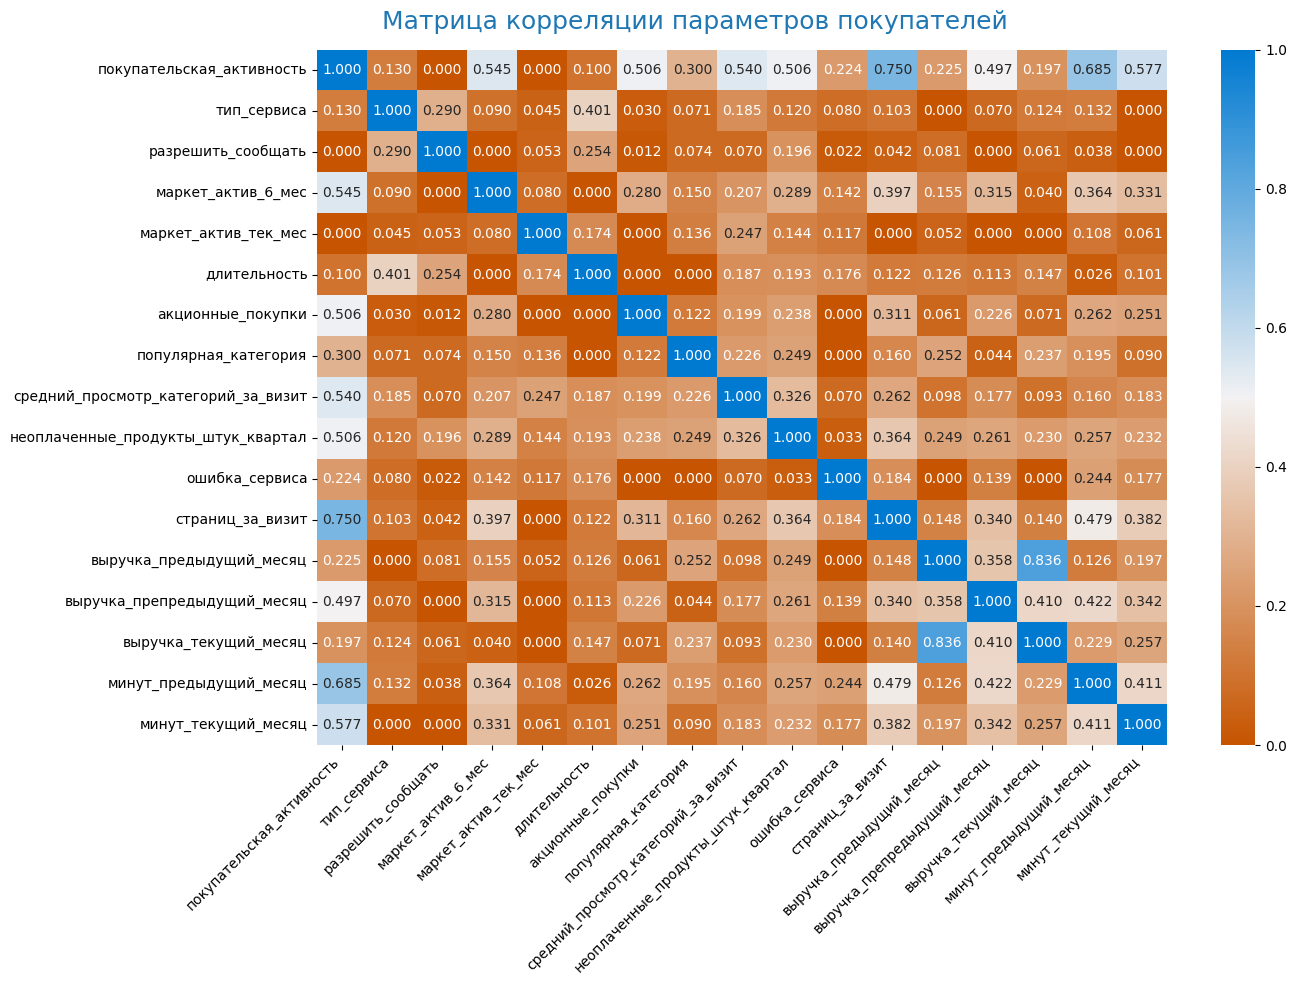

In [51]:
quant_columns = [i for i in list(market_total.columns) if i not in qual_columns]

# Функция вывода матрицы коэффициентов корреляции Фи
def show_heatmap(
    data, title, interval_cols, figsize = (14, 10), 
    annot=True, fmt=".3f"
):
    plt.figure(figsize=figsize)
    sns.heatmap(
        (
            data.phik_matrix(interval_cols=interval_cols)
        ), 
        annot=annot, fmt=fmt,
        cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
    )
    plt.suptitle(title, color="C0", size=18)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
show_heatmap(
    market_total, 
    "Матрица корреляции параметров покупателей",
    quant_columns
)

Наибольшая корреляция целевого признака наблюдается с признаком количества страниц за визит - 0.750, также заметная корреляция с признаками времени посещения сервиса за предыдущий и текущий месяц - 0.685 и 0.577 соответственно. Немного ниже корреляция с признаками средней маркетинговой активности за 6 месяцев, средний просмотр категорий за визит, акционные покупки и неоплаченные продукты - 0.545, 0.540, последние два по 0.506 соответственно.

Между признаками можно выявить наибльшую корреляцию по выручке между текущим и предыдущим месяцем - 0.836. По остальным признакам можно отметить умеренную корреляцию между средним количеством страниц за визит, временем на сайте и маркетинговой активностью за 6 месяцев, а также можно отметить корреляцию между длительностью регистрации и типом сервиса.

Мультиколлинеарность отсустствует, так как нет признаков между которыми весьма высокая корреляция выше 0.9-0.95

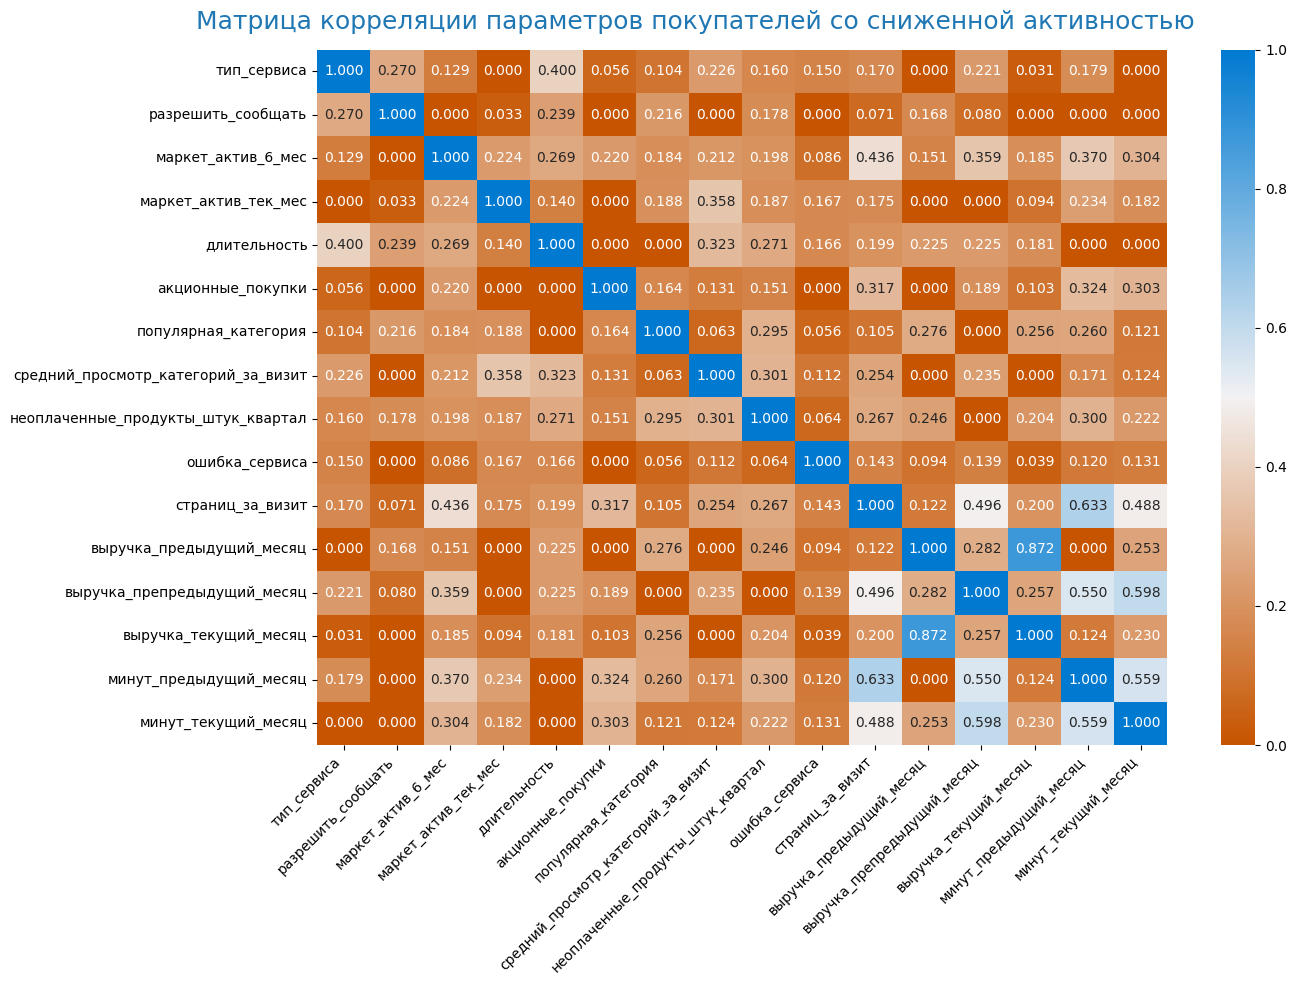

In [52]:
show_heatmap(
    market_total.query(
        "покупательская_активность == 'Снизилась'"
    ).drop("покупательская_активность", axis=1), 
    "Матрица корреляции параметров покупателей со сниженной активностью",
    quant_columns
)

По покупателям, у которых наблюдается снижение пользовательской активности корреляция заметно увеличивается между признаками количество страниц за визит и проведенным на сайте временем, особенно за предыдущий месяц - 0.633, а также с выручкой за препредыдущий месяц.

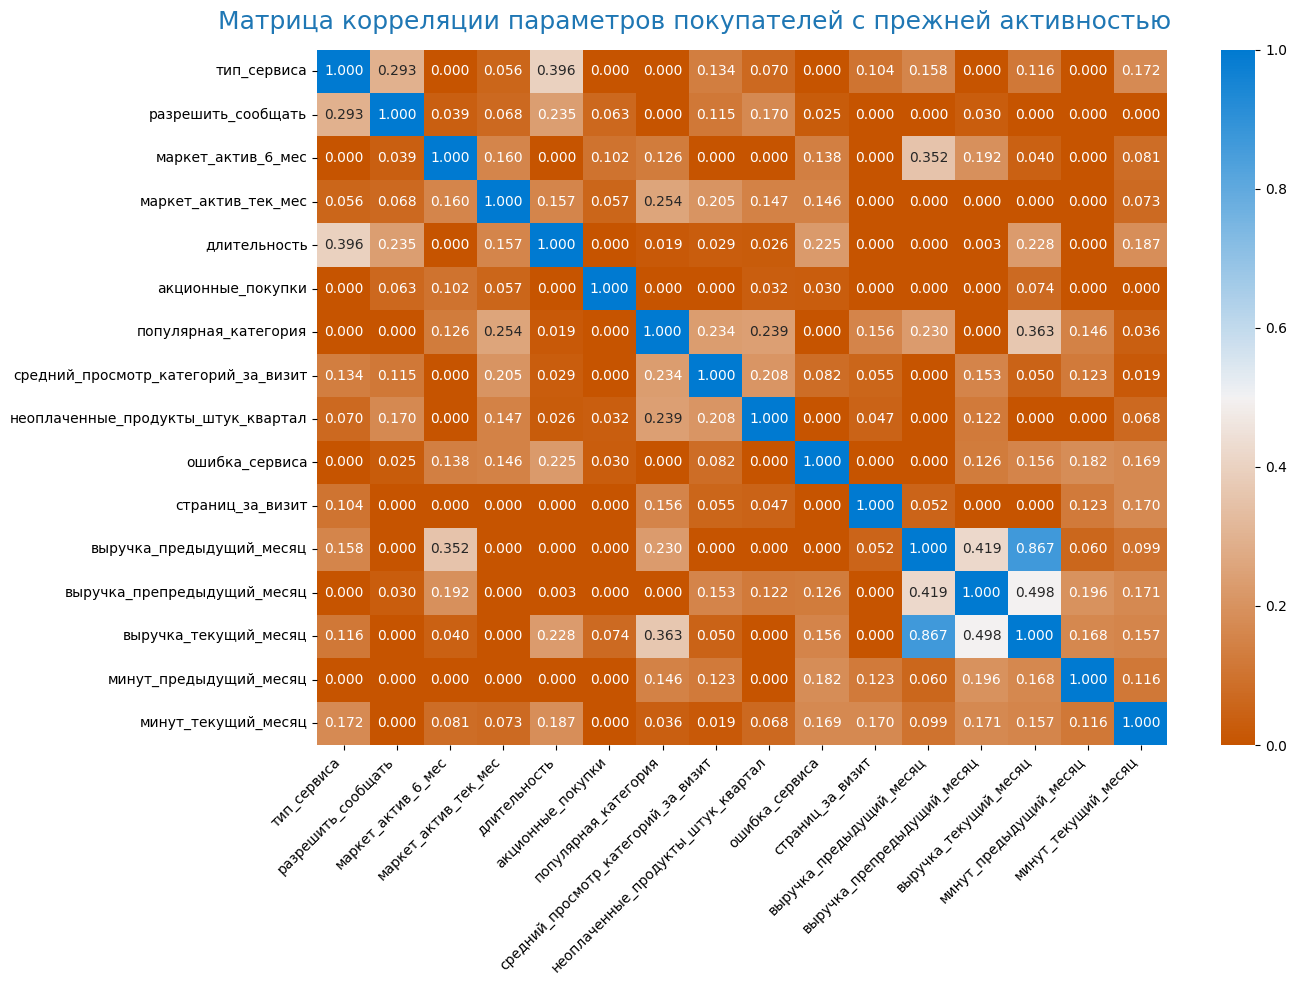

In [53]:
show_heatmap(
    market_total.query(
        "покупательская_активность != 'Снизилась'"
    ).drop("покупательская_активность", axis=1), 
    "Матрица корреляции параметров покупателей с прежней активностью",
    quant_columns
)

По пользователям с прежним уровнем покупательской активностью наблюдается высокая корреляция между текущей выручкой и выручкой препредыдущего месяца. По другим показателям заметно снижение общей корреляции.

### Промежуточные выводы

Проведен корреляционный анализ, по результатам которого можно отметить следующее:
1. По ключевому признаку высокая корреляция наблюдается только с количеством страниц за визит - 0.75, также заметная корреляция со следующими признаками:
    - временем на сайте за предыдущий и текущий месяц - 0.685 и 0.577 соответственно;
    - средняя маркетинговая активность на сайте за 6 месяцев и средний просмотр категорий за визит - 0.545 и 0.54 соответственно;
    - акционные покупки и неоплаченные продукты - 0.506 с каждым признаком.
2. Между признаками имеется высокая корреляция только по признакам выручка за текущий месяц и выручка за предыдущий месяц - 0.836, по остальным признакам низкая либо умеренная корреляция ниже 0.5.
3. По покупателям со снизившейся пользовательской активностью возрастает между признаками выручки за текущий и предыдущий месяц до 0.872, также заметно вырастает корреляция между признаками:
    - сраниц за визит и проведенным временем на сайте - 0.633 за предыдущий месяц и 0.488 за текущий, 
    - выручка за препредыдущий месяц и временем на сайте - 0.598 за текущий месяц и 0.55 за предыдущий;
    - временем на сайте за текущий и предыдущий месяц - 0.559.
4. По покупателям с прежней пользовательской активностью корреляция между признаками сильно снижается, при этом корреляция возрастает между признаками выручки, в том числе за предыдущий и текущий месяц до 0.867, а также появляется умеренная корреляция между выручкой за текущий месяц и препредыдущий месяц - 0.498 и между выручкой за предыдущий и препредыдущий месяцы до 0.419.

## Использование пайплайнов

Проведем разделение выборки на тренировочную и тестовую в соотношении 75% / 25%. Так как в данных имеется дисбаланс классов, нужно обязательно выполнить стратификацию данных. Также определим количественные и категориальные признаки для кодирования и масштабирования. 

In [54]:
# Создание тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    market_total.drop(["покупательская_активность"], axis=1),
    market_total["покупательская_активность"],
    test_size = 0.4,
    random_state = RANDOM_STATE,
    stratify = market_total["покупательская_активность"]
)

# Кодирование целевого признака
le = LabelEncoder()
le.fit(y_train)
le.classes_ = np.array(["Прежний уровень", "Снизилась"])
y_train = le.transform(y_train)
y_test = le.transform(y_test) 

# вывод информации о выборках
print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# определение количественных и категориальных признаков для кодирования
ohe_cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
    'минут_предыдущий_месяц', 'минут_текущий_месяц'
]
print("Общее количество столбцов для кодирования и масштабирования:",
     len(ohe_cols) + len(num_cols))

Размер тренировочной выборки: (777, 16)
Размер тестовой выборки: (519, 16)
Общее количество столбцов для кодирования и масштабирования: 16


Целевой признак закодирован посредством LabelEncoder, целевое значение равно 1, так как значение `Снизилась` является вторым элементом списка (после обучения заданы ).

В качестве признаков для OHE-кодирования определены `покупательская_активность`, `тип_сервиса`, `разрешить_сообщать` которые имеют только 2 значения и `популярная_категория`. Остальные признаки определены как количественные к которым будет также применяться масштабирование.

Создадим пайплайн для подготовки, кодирования и масштабирования данных, в рамках которого категориальные признаки будут подготовлены - заполнение пропусков будет производиться модой, в том числе неизвестные значения после Ordinal-кодирования.

In [55]:
# создаём пайплайн для подготовки признаков из списка ohe_cols: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_cols: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
#ord_pipe = Pipeline(
#    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('ord',  OrdinalEncoder(
#                handle_unknown='use_encoded_value', unknown_value=np.nan
#            )
#        ),
#     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
#    ]
#)
# убрал OrdinalEncoder

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
#     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, class_weight='balanced', C=2, probability=True))
])

Для задачи бинарной класисификации с несбалансированной выборкой наиболее подходящей является метрика ROC-AUC, которая позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности. Для определения лучшей модели сравним четыре модели `k-ближайших соседей`, `Дерево решений`, `Логистическая регрессия` и `Метод опорных векторов`. Для определения лучшей модели воспользуемся автоматизированным инструментом подбора гиперпараметров с кросс-валидацией.

In [56]:
# список моделей для и гиперпараметры для определения лучшей модели
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': ['passthrough']   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        "models__max_depth": range(2, 5),
        "models__max_features": range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', penalty='l1', 
            class_weight='balanced'
        )],
        "models__C": range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced', probability=True)],
        'models__kernel': ['rbf','sigmoid', 'poly'],
        "models__C": range(1, 5),
        # при использовании gamma зависает и не реагирует долгое время
        #"models__gamma": range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

search_cv = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=30,
    random_state=RANDOM_STATE
)

start = time.time()

search_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('num',
                                                                               StandardScale...
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(class_weight='balanced',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__kernel': ['rbf', 'sigmoid',
                                                            'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Лучшая модель определена SVC с ядром по умолчанию `rbf` и параметром регуляризации равным 1. Оценим качество предсказаний на тестовой выборке.

In [57]:
# Предсказание модели
y_test_pred = search_cv.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred):0.3f}')

Метрика ROC-AUC на тестовой выборке: 0.918


На тестовой выборке значение метрики ROC-AUC еще выше - 0.918. Проверим какие дополнительно модели имеют высокие показатели метрики.

In [58]:
pd.DataFrame(search_cv.cv_results_).sort_values("rank_test_score").head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4        0.069247      0.006145         0.013601        0.001020   
29       0.011801      0.000749         0.007000        0.000895   
7        0.018135      0.002569         0.008335        0.000842   
16       0.013623      0.002348         0.009201        0.000747   
26       0.064026      0.014042         0.004406        0.000490   
13       0.047402      0.001357         0.009600        0.000798   
18       0.069954      0.017523         0.012199        0.002715   
15       0.062437      0.012754         0.013602        0.003774   
22       0.067147      0.018125         0.010199        0.004120   
10       0.065649      0.003964         0.009402        0.001020   

   param_preprocessor__num param_models__kernel  param_models__C  \
4           RobustScaler()                  rbf              1.0   
29        StandardScaler()                  NaN              1.0   
7           MinMaxScaler()                  NaN              1.0   
16        StandardScaler()                  NaN              4.0   
26             passthrough                  NaN              1.0   
13        StandardScaler()                 poly              2.0   
18          RobustScaler()                 poly              4.0   
15          MinMaxScaler()                 poly              1.0   
22        StandardScaler()              sigmoid              1.0   
10          MinMaxScaler()                 poly              2.0   

                                         param_models  \
4   SVC(class_weight='balanced', probability=True,...   
29  LogisticRegression(class_weight='balanced', pe...   
7   LogisticRegression(class_weight='balanced', pe...   
16  LogisticRegression(class_weight='balanced', pe...   
26  LogisticRegression(class_weight='balanced', pe...   
13  SVC(class_weight='balanced', probability=True,...   
18  SVC(class_weight='balanced', probability=True,...   
15  SVC(class_weight='balanced', probability=True,...   
22  SVC(class_weight='balanced', probability=True,...   
10  SVC(class_weight='balanced', probability=True,...   

    param_models__max_features  param_models__max_depth  \
4                          NaN                      NaN   
29                         NaN                      NaN   
7                          NaN                      NaN   
16                         NaN                      NaN   
26                         NaN                      NaN   
13                         NaN                      NaN   
18                         NaN                      NaN   
15                         NaN                      NaN   
22                         NaN                      NaN   
10                         NaN                      NaN   

    param_models__n_neighbors  \
4                         NaN   
29                        NaN   
7                         NaN   
16                        NaN   
26                        NaN   
13                        NaN   
18                        NaN   
15                        NaN   
22                        NaN   
10                        NaN   

                                               params  split0_test_score  \
4   {'preprocessor__num': RobustScaler(), 'models_...           0.910536   
29  {'preprocessor__num': StandardScaler(), 'model...           0.888695   
7   {'preprocessor__num': MinMaxScaler(), 'models_...           0.883977   
16  {'preprocessor__num': StandardScaler(), 'model...           0.886598   
26  {'preprocessor__num': 'passthrough', 'models__...           0.886074   
13  {'preprocessor__num': StandardScaler(), 'model...           0.878735   
18  {'preprocessor__num': RobustScaler(), 'models_...           0.889568   
15  {'preprocessor__num': MinMaxScaler(), 'models_...           0.854098   
22  {'preprocessor__num': StandardScaler(), 'model...           0.872794   
10  {'preprocessor__num': MinMaxScaler(), 'models_...           0.834003   

    split1_test_score  spli

Лучшая модель по метрике ROC AUC - SVM с ядром `rbf`, среднее значение метрики после кросс-валидации превышают 0.9. Также достаточно высокие значения метрики показывают модели логистической регрессии, SVM с ядром `poly` и `sigmoid` в пределах значений 0.87-0.89.

### Промежуточные выводы

В качестве наиболее подходящей метрики выбрана метрика ROC-AUC так как имеется несбалансированная выборка для задачи бинарной классификации.

Подготовлен пайплайн который производит подготовку данных и используется для автоматизированного поиска наилучшей модели с помощью RandomizedSearchCV:
1. Все категориальные признаки кодировались с помощью OneHotEncoder, целевой кодировался предварительное LabelEncoder;
2. При кодировании пустые значения заполняются самыми распространенными значениями признаков (мода).
3. Количественные признаки кодировались с помощью StandardScaler, MinMaxScaler, RobustScaler, либо использовались без кодирования.
4. Для поиска налиучшей использовались модели `k-ближайших соседей`, `Дерево решений`, `Логистическая регрессия` и `Метод опорных векторов`.

По результатам поиска наилучшей моделью определен метод опорных векторов со стандартным ядром rbf и параметром регуляризации равным 1. Значение метрики ROC-AUC в среднем составило довольно высокое значение - 0.913 при кросс-валидации на тренировочной выборке. Для тестовой выборки данная метрика показывает более высокое значение - 0.918. Также довольно высокие показатели у моделей логистической регрессии, SVM с ядром `poly` или `sigmoid` при кросс-валидации.

## Анализ важности признаков

### Модель SVM

In [59]:

cols = list(search_cv.best_estimator_["preprocessor"]["ohe"]["ohe"].get_feature_names_out()) + num_cols
def model_pred(data_array):
    return search_cv.predict_proba(
        pd.DataFrame(data_array, columns=cols)
    )

shap_explainer = shap.KernelExplainer(
    search_cv.best_estimator_["models"].predict_proba, 
    pd.DataFrame(
        search_cv.best_estimator_["preprocessor"].transform(
            X_train.sample(75, random_state=RANDOM_STATE)),
            columns=cols
    ),
    link="logit"
)

shap_values = shap_explainer(
    pd.DataFrame(
        search_cv.best_estimator_["preprocessor"].transform(
            X_test.sample(25, random_state=RANDOM_STATE)),
            columns=cols)
)

  0%|          | 0/25 [00:00<?, ?it/s]

Модель SVM плохо интерпретируется в отличие от других использованных моделей. Для анализа важности признаков можно воспользоваться инструментом KernelExplainer, который использует специальную взвешенную линейную регрессию для вычисления важности каждого признака (значения Шепли из теории игр) и подходит для объяснения выходных данных любой функции. Но для данного инструмента требуется больше вычислительных ресурсов и в данном случае (в целях экономии времени) используется не вся выборка, что снижает информативность.

Целевой признак - это покупательская активность, позитивное значение которого определяет снижение покупательской активности. Оценим график общей значимости признаков:

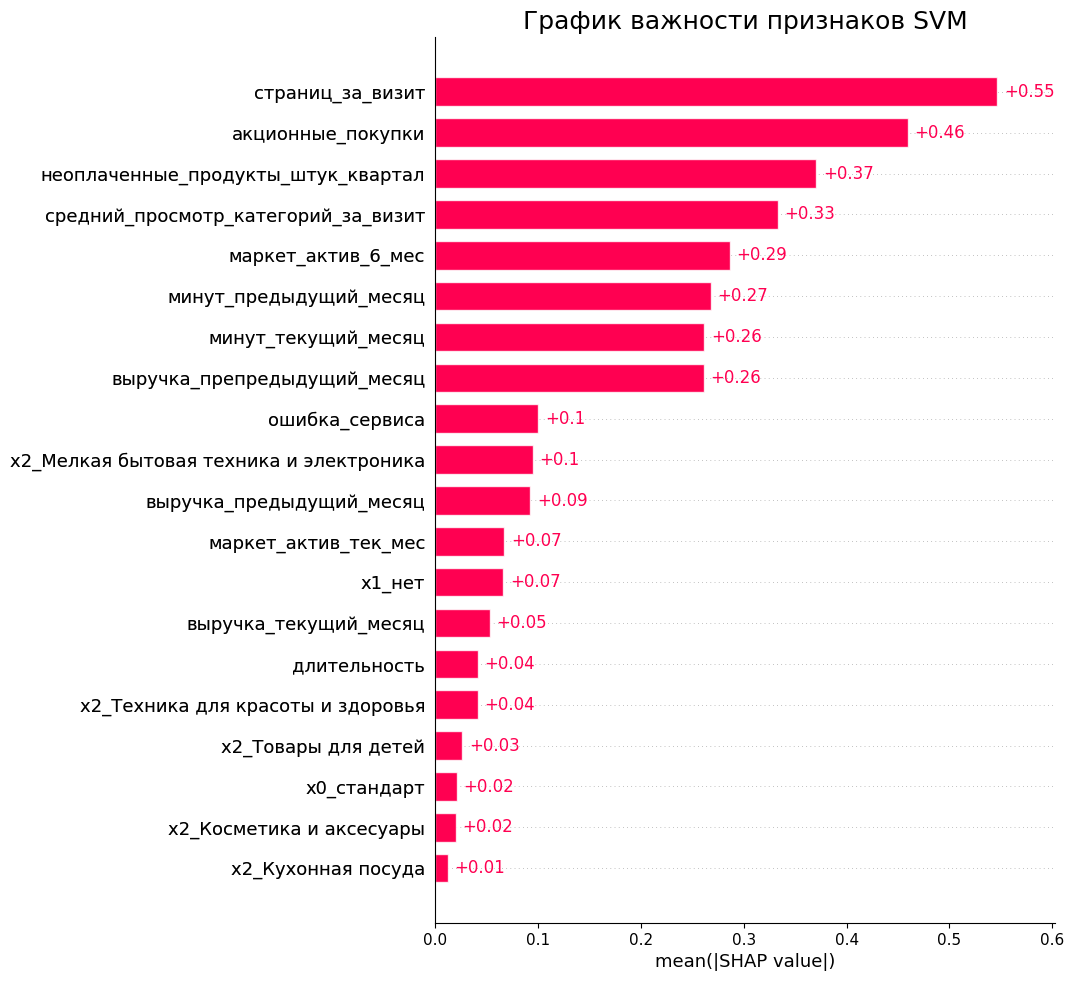

In [60]:
shap.plots.bar(shap_values[:,:,1], max_display=21, show=False)
plt.title("График важности признаков SVM", size=18)
plt.show()

Наиболее значимым признаком можно отметить `страниц_за_визит`. С небольшим отрывом по убыванию идут признаки - `акционные_покупки`, `неоплаченные_продукты_штук_квартал`, `средний_просмотр_категорий_за_визит`, `маркет_актив_6_мес`. Признаки `минут_предыдущий_месяц`, `выручка_препредыдущий_месяц` и `минут_текущий_месяц` имеют близкое значение порядка +0,26. Остальные категории имеет заментно меньшее влияние.

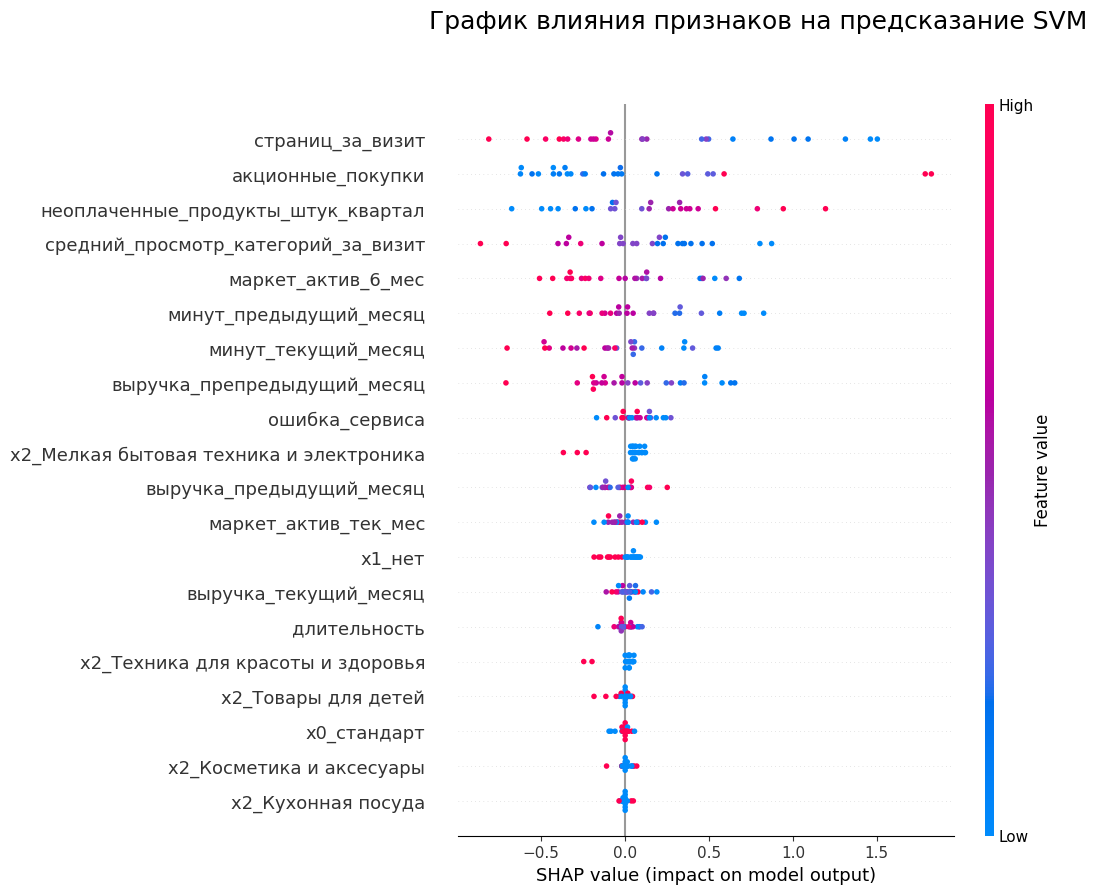

In [61]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=21, show=False)
plt.suptitle("График влияния признаков на предсказание SVM", size=18)
plt.show()

По влиянию признаков на позитивное предсказание (снижение покупательской активности) можно отметить следующее:
1. Прямое влияние на вероятность позитивного предсказания имеют высокие значения признаков - `акционные_покупки` и `неоплаченные_продукты_штук_квартал`, а также `выручка_предыдущий_месяц`.
2. Повышает вероятность позитивного предсказания низкие значения остальных признаков;
3. Стоит отметить признаки `популярная_категория`, `выручка_предыдущий_месяц` и `маркет_актив_тек_мес` которые имеют явно не линейное распределение влияния по значениям, где значение может оказывать разнонаправленное влияние на предсказание целевого значения.
4. Выручка за предыдущий месяц вероятно имеет довольно противоречивое влияние, так как высокие и низкие значения в достаточной мере присутствуют как при положительном так и при отрицательном предсказании.

При анализе признаков модели SVM используется только часть выборки, что может быть недостаточно показательно, либо необходимо запускать на довольно длительное время инструмент KernelExplainer. При анализе моделей было отмечено, что достаточно высокие показатели метрики имеет модель логистической регрессии. Можно сравнить влияние признаков на модель логистической регрессии с SVM.

### Логистическая регрессия

Метрика ROC-AUC на тестовой выборке: 0.914


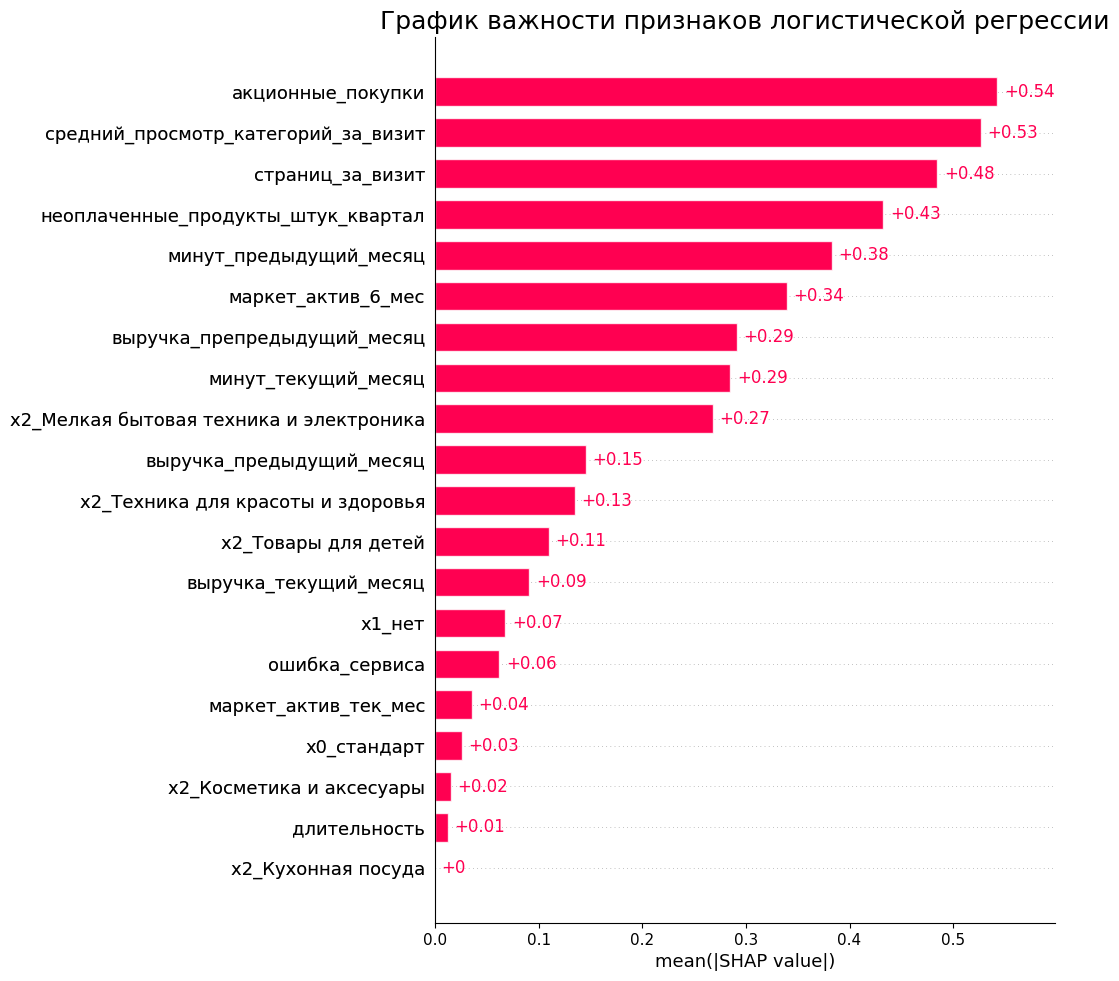

In [62]:
# пайплайн для подготовки данных для модели логистической регрессии
data_logr_prep = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
#     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и логистическая регрессия
pipe_lr = Pipeline([
    ('prep', data_logr_prep),
    ('models', search_cv.cv_results_["param_models"][29])
])

pipe_lr.fit(X_train, y_train)

# Предсказание модели
y_test_pred = pipe_lr.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred):0.3f}')

shap_explainer = shap.LinearExplainer(
    pipe_lr.named_steps["models"], 
    pipe_lr.named_steps["prep"].transform(X_test)
)
shap_values = shap_explainer(pd.DataFrame(
    pipe_lr.named_steps["prep"].transform(X_test),
    columns=cols
))

shap.plots.bar(shap_values, max_display=21, show=False)
plt.title("График важности признаков логистической регрессии", size=18)
plt.show()

Для логистической регрессии метрика ROC-AUC для тестовой выборки показывает даже более высокие результаты. По важности признаки немного поменялись местами. На первое место по важности для логистической регрессии вышел признак `акционные_покупки`, также выше расположились признаки `средний_просмотр_категорий_за_визит` и `минут_предыдущий_месяц`. Ниже стала важность признаков `страниц_за_визит`, который для модели SVM был на первом месте, а также признаков `неоплаченные_продукты_штук_квартал`, `минут_текущий_месяц`, `маркет_актив_6_мес` и `выручка_препредыдущий_месяц`. 

Остальные признаки имеют гораздо более низкую важность, при этом существенно сильно снизилась важность признаков `выручка_предыдущий_месяц` и `выручка_текущий_месяц`, а также заметно снизилась важность признаков `ошибка_сервиса` и `длительность` по сравнению с моделью SVM.

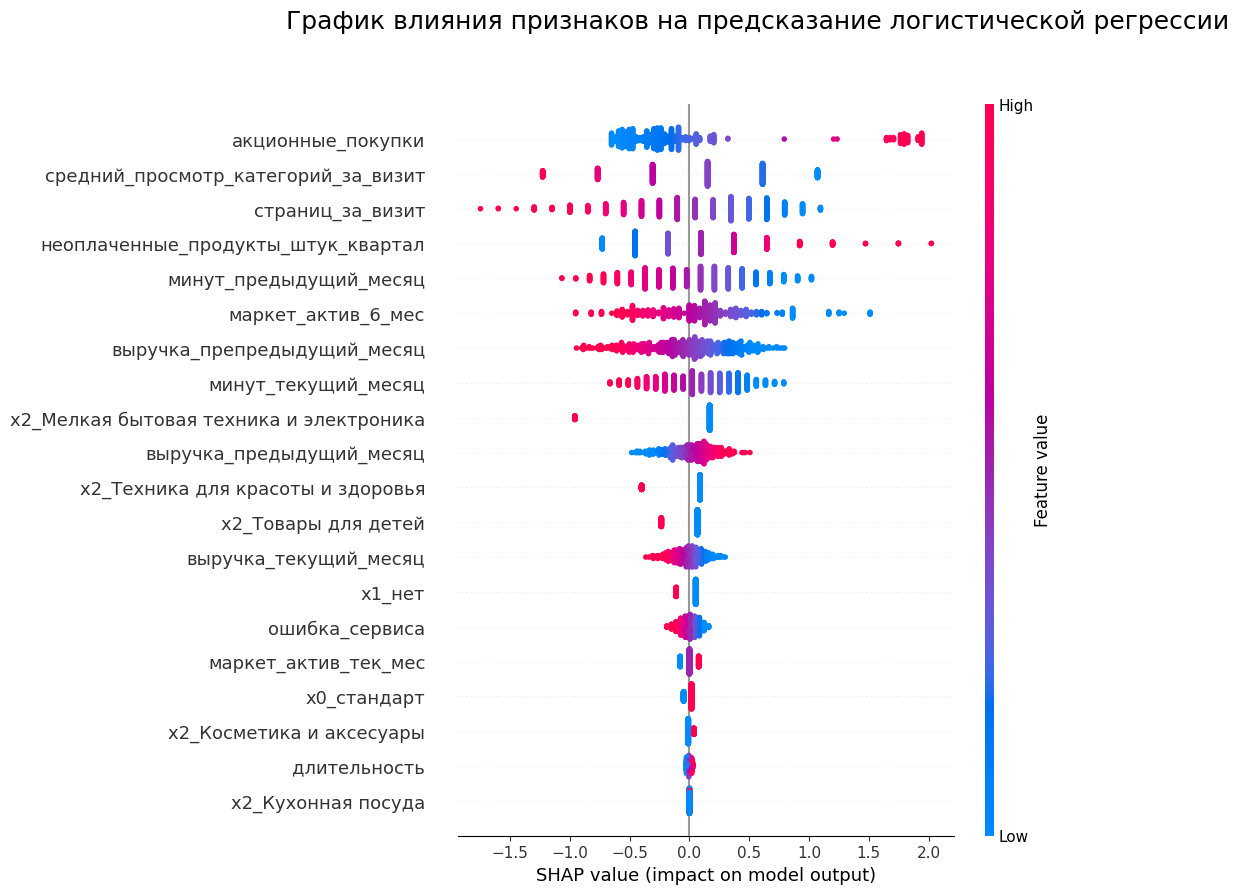

In [63]:
shap.plots.beeswarm(shap_values, max_display=21, show=False)
plt.suptitle("График влияния признаков на предсказание логистической регрессии", size=18)
plt.show()

Влияние признаков аналогично как и для модели SVM - прямое влияние оказывают только признаки `акционные_покупки`, `неоплаченные_продукты_штук_квартал` и `выручка_предыдущий_месяц`, остальные в основном обратное влияние - низкие значения приводят к положительному прогнозу модели. 

### Промежуточные выводы

Проведен анализ важности признаков обученных моделей:
1. Наиболее важными признаками, влияющими на снижение пользовательской активности, являются акционные покупки и средний просмотр категорий за визит, страниц за визит и неоплаченные продукты за квартал, а также немаловажным фактором является количество неоплаченных продуктов за квартал.
2. Достаточно важными признаками можно отметить количество минут на сайте в текущем и предыдущем месяцах, маркетинговая активность за 6 месяцев, а также выручка за месяц до предыдущего.
3. Также достаточное влияние оказывают популярные категории - мелкая бытовая техника и электроника, а также техника для красоты и здоровья.
4. Остальные признаки в целом имеют определенное влияние, очень низкое влияние оказывает длительность регистрации и тип сервиса и маркетинговая активность текущего месяца.

Можно определить предварительный портрет пользователя, активность которого снижается:
1. Более высокое количество неоплаченных продуктов за квартал и высокая доля акционных покупок за последние пол года.
2. В целом низкие показатели количества просмотров категорий и страниц за визит, а также низкое количество минут на сайте за предыдущий и текущий месяцы, а также низкая маркетинговая активность за пол года и низкий показатель выручки за месяц до предыдущего.

## Сегментация покупателей

Для анализа будет выбран сегмент покупателей, приносящих достаточно высокую прибыль и имеющих высокую вероятность прогноза к снижению пользовательской активности, так как это наиболее значимый сегмент для целей проекта.

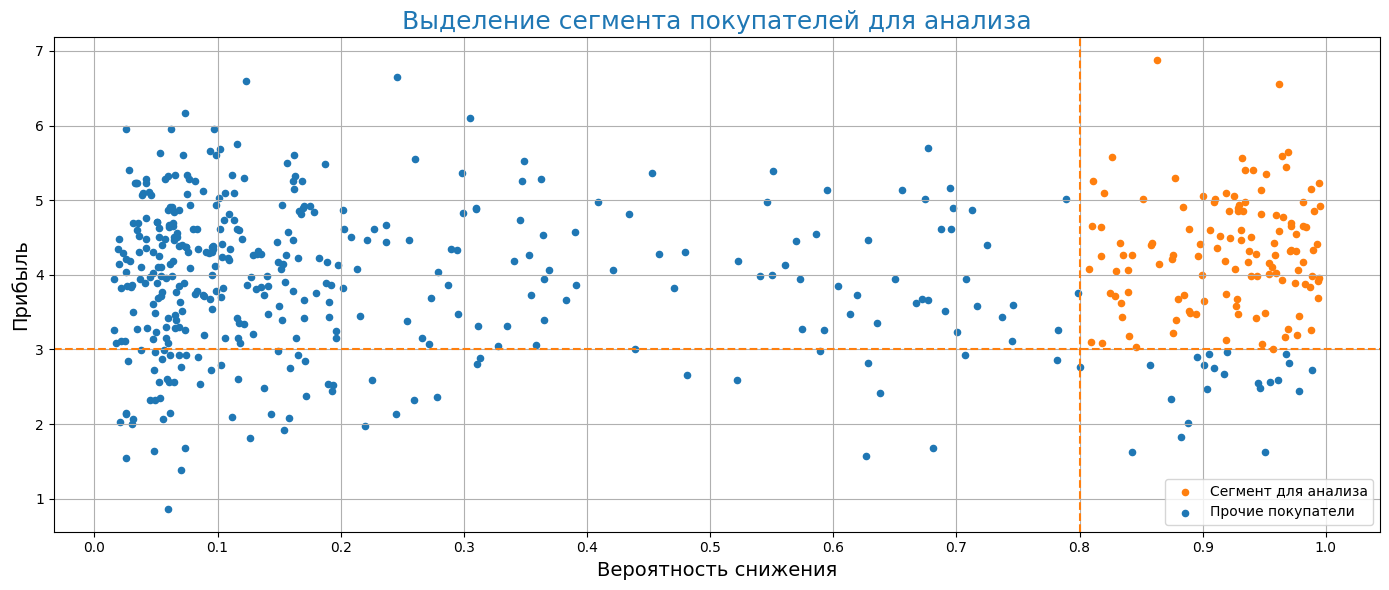

Значение метрики Precision:  0.96


In [64]:
# прогнозирование вероятности снижения и объединение данных
pred_values = pd.DataFrame(
    {
        "вероятность_снижения": search_cv.predict_proba(X_test)[:,1]
    }, 
    index=X_test.index
).join(money).join(market_total)

# определение порогов для прибыли и вероятности снижения
money_thold = 3
proba_thold = 0.8

# сегментация по порогу
pred_values["сегмент"] = pred_values.apply(
    lambda x: "Сегмент для анализа" if (
        x["прибыль"] > money_thold and x["вероятность_снижения"] > proba_thold
    ) else "Прочие покупатели",
    axis=1
)

# вывод диаграммы разброса
fig, ax = plt.subplots(figsize=(14, 6))
pred_values.query("сегмент == 'Сегмент для анализа'").plot(
    kind="scatter", x="вероятность_снижения", y="прибыль",
    ax=ax, color="C1", grid=True
)
pred_values.query("сегмент == 'Прочие покупатели'").plot(
    kind="scatter", x="вероятность_снижения", y="прибыль",
    ax=ax, color="C0", grid=True
)
plt.title("Выделение сегмента покупателей для анализа",
             size=18, color="C0")
plt.ylabel("Прибыль", size=14)
plt.xlabel("Вероятность снижения", size=14)
plt.xticks(np.linspace(0,1,11))
plt.legend(["Сегмент для анализа", "Прочие покупатели"])
plt.axhline(y=money_thold, color="C1", linestyle="--")
plt.axvline(x=proba_thold, color="C1", linestyle="--")
plt.tight_layout()
plt.show()

# Вывод метрики для оценки ложноположительных ответов
print("Значение метрики Precision: ", precision_score(
    pred_values.query("сегмент == 'Сегмент для анализа'")["покупательская_активность"].apply(
        lambda x: 1 if x == "Снизилась" else 0),
    pred_values.query("сегмент == 'Сегмент для анализа'")["сегмент"].apply(
        lambda x: 1 if x == "Сегмент для анализа" else 0)
))

Определен сегмент покупателей для анализа:
1. Покупатели, значение среднемесячной прибыли по которым выше 3, чтобы отсечь покупателей с низкой прибылью;
2. Покупатели, вероятность снижения пользовательской активности которых превышает 80%. Доля ложноположительных предсказаний для данного сегмента невысокая, метрика Precision равна 0.96.

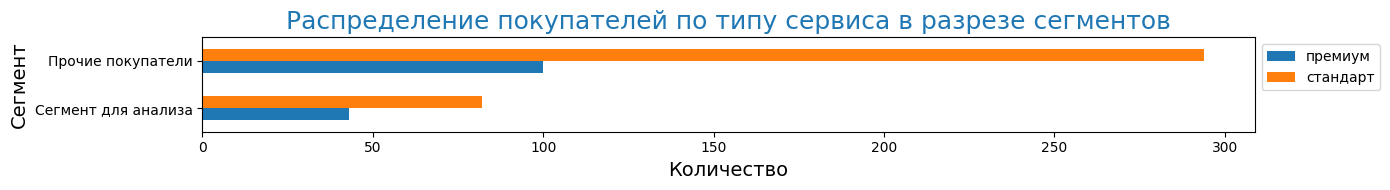

In [65]:
show_barh(
    pred_values.pivot_table(
        index="сегмент", columns="тип_сервиса",
        values="вероятность_снижения", aggfunc="count"
    ),
    "Распределение покупателей по типу сервиса в разрезе сегментов", "Сегмент"
)

По типу сервиса в интересующем сегменте имеется небольшое преобладание премиум подписчиков.

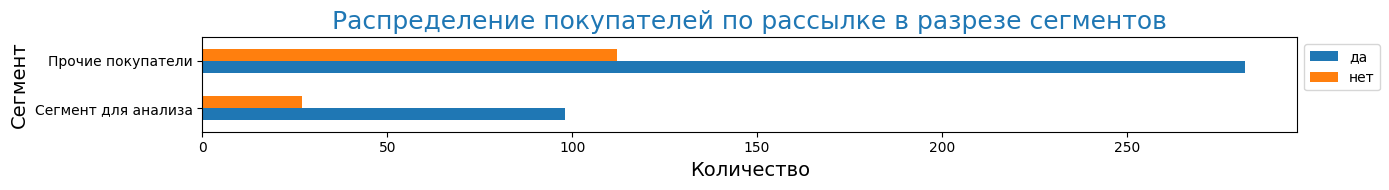

In [66]:
show_barh(
    pred_values.pivot_table(
        index="сегмент", columns="разрешить_сообщать",
        values="вероятность_снижения", aggfunc="count"
    ),
    "Распределение покупателей по рассылке в разрезе сегментов", "Сегмент"
)

По подписке на рассылку распределение также близкое, небольшое преимущество имеют покупатели с подпиской в рассматриваемом сегменте.

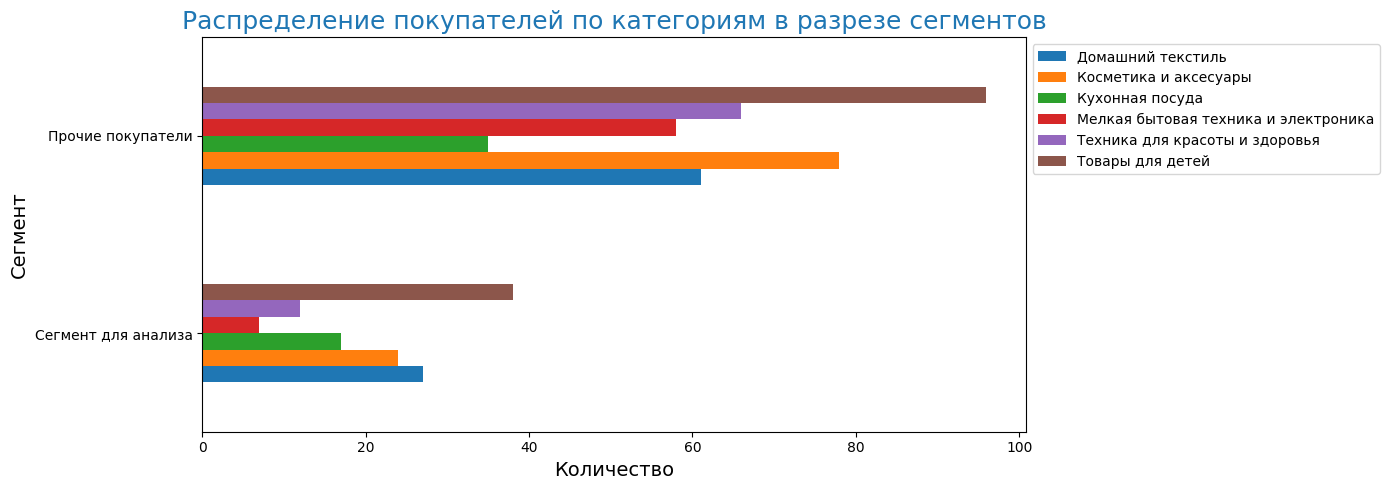

In [67]:
show_barh(
    pred_values.pivot_table(
        index="сегмент", columns="популярная_категория",
        values="вероятность_снижения", aggfunc="count"
    ),
    "Распределение покупателей по категориям в разрезе сегментов", "Сегмент",
    figsize=(14, 5)
)

По популярным категориям в анализируемом сегменте можно отметить следующее:
1. Соотношение покупателей в категории `мелкая бытовая техника и электроника` существенно ниже, чем для остальных покупателей, а также достаточно низкое в категории `Техника для красоты и здоровья`. Даные категории были с наименьшим соотношением пользователей со снизившейся активностью, что вероятно влияет на более высокую вероятность ее снижения.
2. Соотношение покупателей в категории `Косметика и аксесуары` также ниже по сравнению с остальными покупателями. При этом данная категория тоже имела одно из самых высоких соотношений покупателей со снизившейся активностью.
3. Более высокие соотношения покупателей в категории `Кухонная посуда`, `Домашний текстиль` и `Товары для детей` по сравнению с остальными покупателями. Категория `Кухонная посуда` имеет самое высокое соотношение пользователей по целевому признаку, таких покупателей около 14.4% против 8.7% у прочих покупателей. Категории `Товары для детей` и `Домашний текстиль` также имеют достаточно высокое соотношения целевого признака в исходной выборке, их общее соотношение 50,8% в исследуемом сегменте против 40,4% у прочих покупателей.

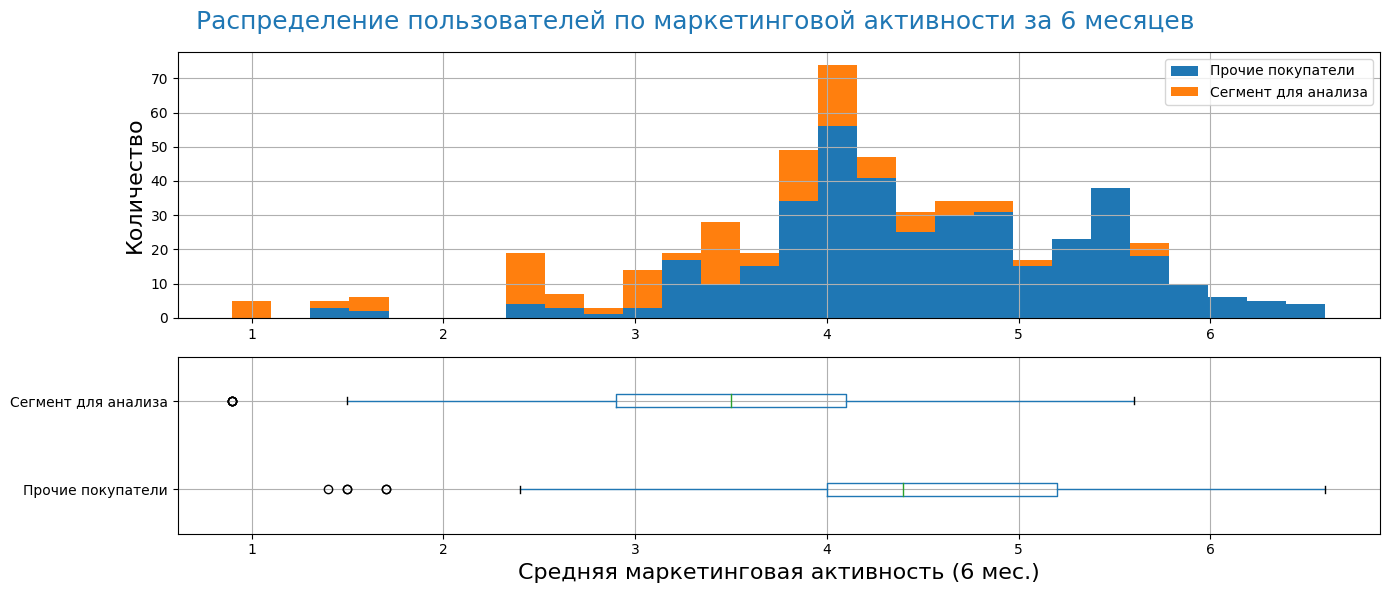

count      mean       std  min  25%  50%  75%  max  \
Сегмент                                                                   
Прочие покупатели    394.0  4.509137  0.882235  1.4  4.0  4.4  5.2  6.6   
Сегмент для анализа  125.0  3.454400  1.011108  0.9  2.9  3.5  4.1  5.6   

                         Gaussian   p_value  
Сегмент                                      
Прочие покупатели    Probably NOT  0.000005  
Сегмент для анализа  Probably NOT  0.000614

In [68]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="маркет_актив_6_мес"
    ),
    "Распределение пользователей по маркетинговой активности за 6 месяцев",
    "Средняя маркетинговая активность (6 мес.)", 
    columns="Сегмент", bins=28, boxplot=True, figsize=(14, 6)
)

По гистограмме распределения пользователей по маркетинговой активности за 6 месяцев заметно, что в выбранном сегменте более низкая маркетинговая активность для пользователей с высоким риском снижения пользовательской активности. Основная масса покупателей маркетинговая активность находится между 3 и 4.1, в то время как для остальных покупателей средняя маркетинговая активность находится между 4 и 5.2.

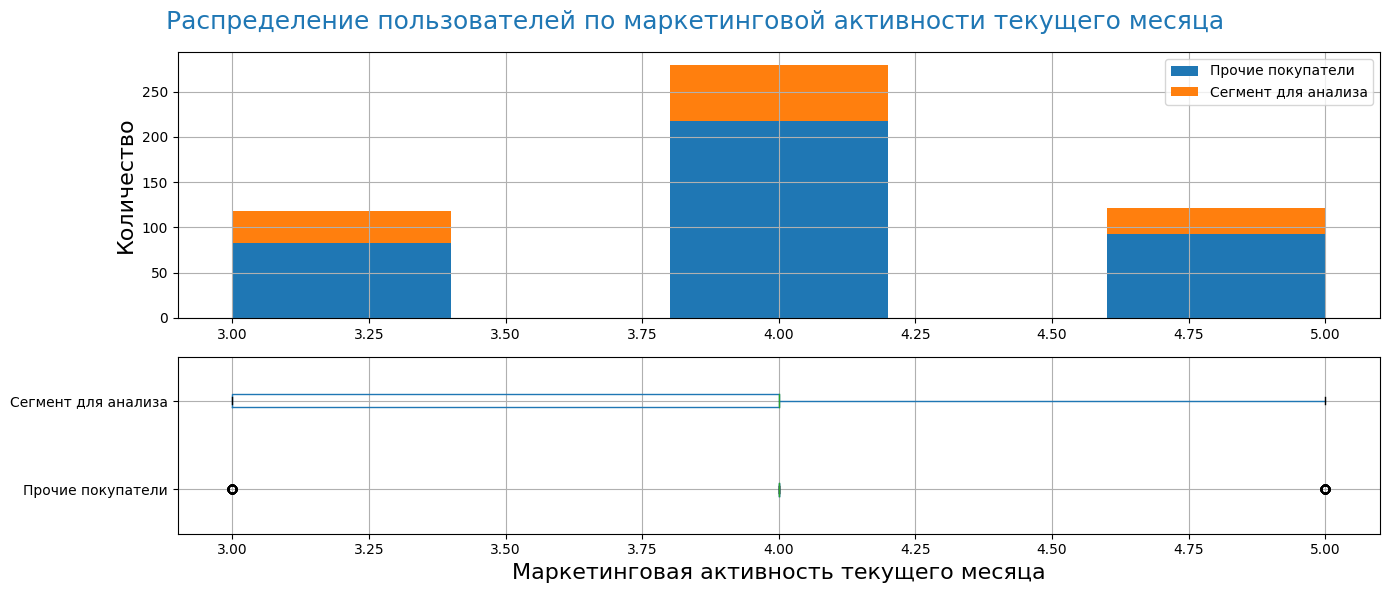

count      mean       std  min  25%  50%  75%  max  \
Сегмент                                                                   
Прочие покупатели    394.0  4.025381  0.668724  3.0  4.0  4.0  4.0  5.0   
Сегмент для анализа  125.0  3.944000  0.710565  3.0  3.0  4.0  4.0  5.0   

                         Gaussian       p_value  
Сегмент                                          
Прочие покупатели    Probably NOT  8.604178e-22  
Сегмент для анализа  Probably NOT  1.549046e-11

In [69]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="маркет_актив_тек_мес"
    ),
    "Распределение пользователей по маркетинговой активности текущего месяца",
    "Маркетинговая активность текущего месяца", 
    columns="Сегмент", bins=5, boxplot=True, figsize=(14, 6)
)

По текущему месяцу также заметно смещение влево к более низким показателям маркетинговой активности текущего месяца для исследуемого сегмента покупателей.

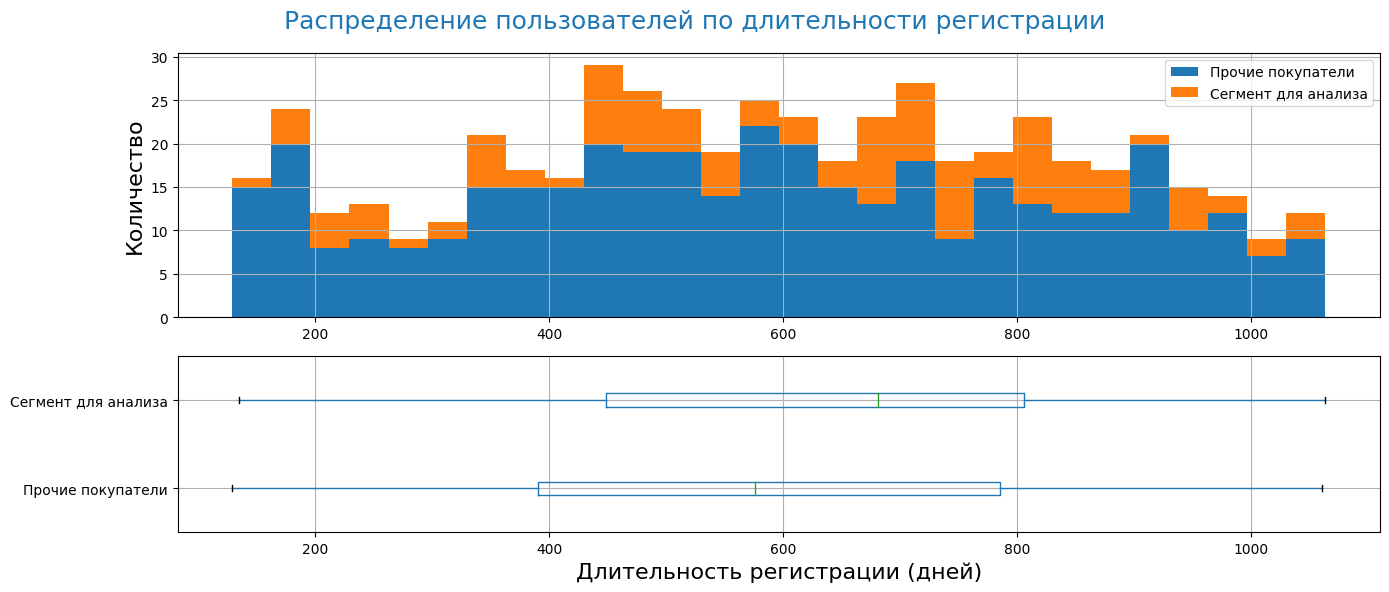

count        mean         std    min    25%    50%  \
Сегмент                                                                   
Прочие покупатели    394.0  584.091371  251.737386  129.0  390.5  576.5   
Сегмент для анализа  125.0  623.376000  233.955733  135.0  449.0  681.0   

                       75%     max      Gaussian       p_value  
Сегмент                                                         
Прочие покупатели    786.0  1061.0  Probably NOT  2.219278e-07  
Сегмент для анализа  806.0  1064.0  Probably NOT  8.379451e-03

In [70]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="длительность"
    ),
    "Распределение пользователей по длительности регистрации",
    "Длительность регистрации (дней)", 
    columns="Сегмент", bins=28, boxplot=True, figsize=(14, 6)
)

Анализируемый сегмент покупателей чаще имеет больший срок, соответственно в основном это не новые покупатели.

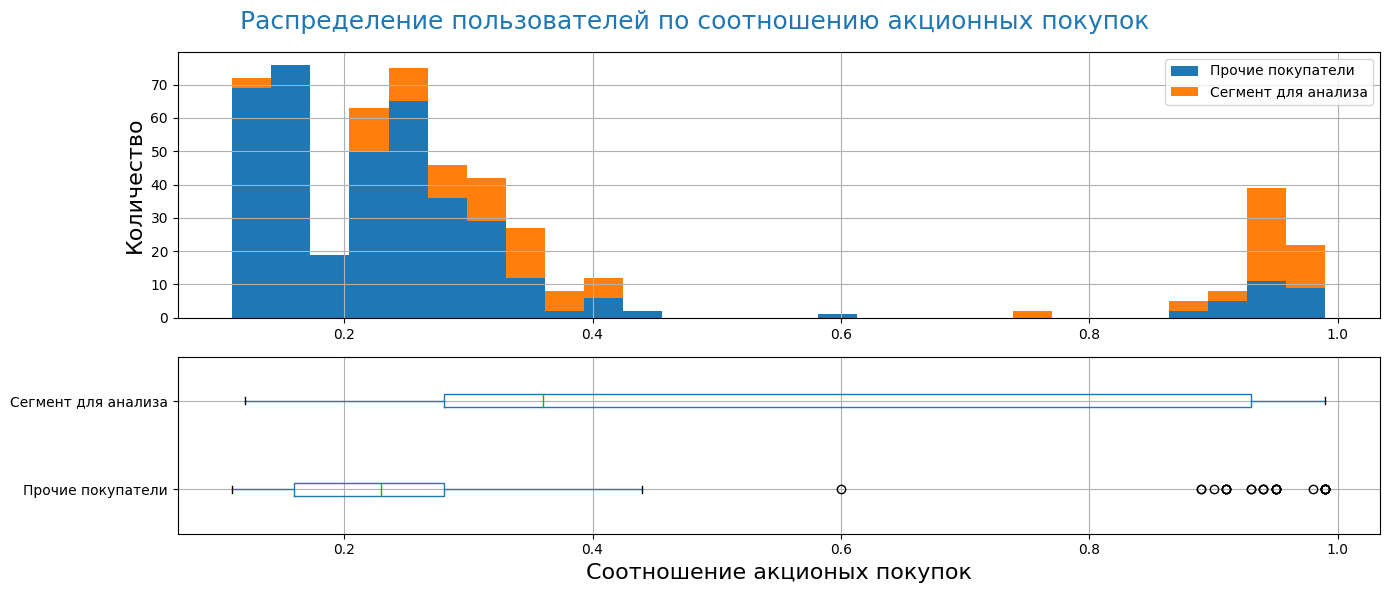

count      mean       std   min   25%   50%   75%   max  \
Сегмент                                                                        
Прочие покупатели    394.0  0.266548  0.198269  0.11  0.16  0.23  0.28  0.99   
Сегмент для анализа  125.0  0.547760  0.320068  0.12  0.28  0.36  0.93  0.99   

                         Gaussian       p_value  
Сегмент                                          
Прочие покупатели    Probably NOT  3.719878e-29  
Сегмент для анализа  Probably NOT  1.016230e-12

In [71]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="акционные_покупки"
    ),
    "Распределение пользователей по соотношению акционных покупок",
    "Соотношение акционых покупок", 
    columns="Сегмент", bins=28, boxplot=True, figsize=(14, 6)
)

Также по графику можно отметить, что в зоне риска в основном пользователи с более высокой долей акционных покупок - от 28% до 93% покупок совершаются по акции. У остальных покупателей в основном доля акционных покупок находится в пределах от 16% до 28%. Возможно какие-то изменения в проводимых акциях могут приводить к снижению пользовательской активности.

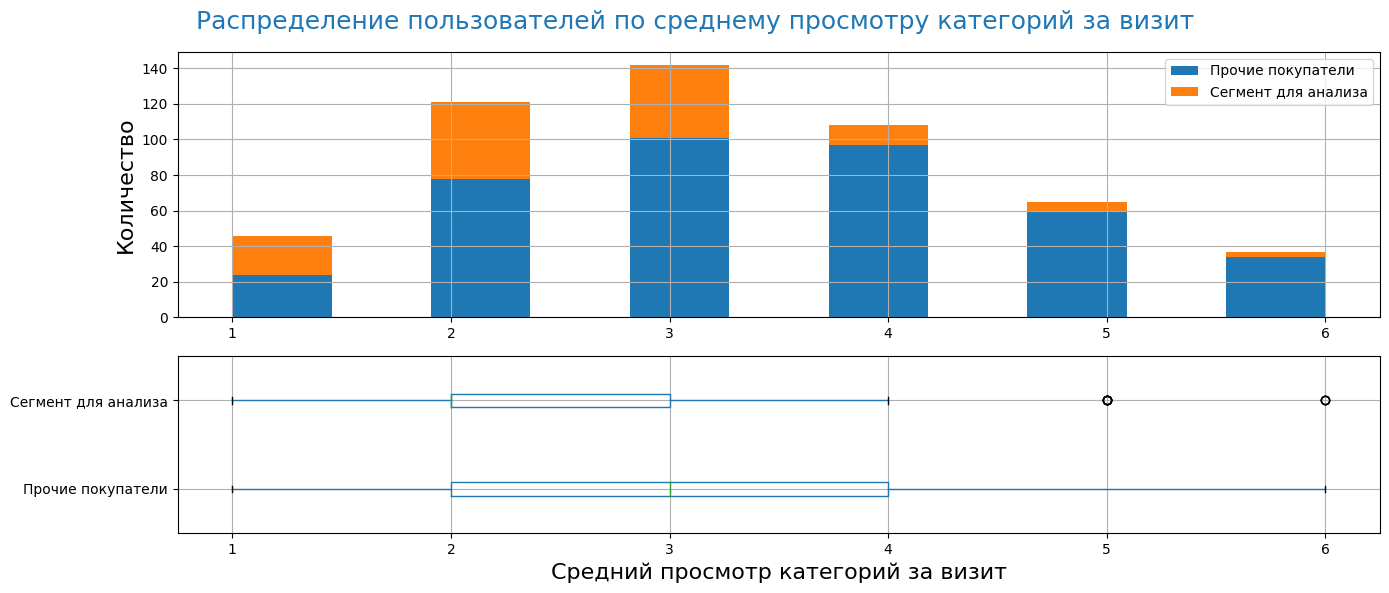

count      mean       std  min  25%  50%  75%  max  \
Сегмент                                                                   
Прочие покупатели    394.0  3.489848  1.355846  1.0  2.0  3.0  4.0  6.0   
Сегмент для анализа  125.0  2.544000  1.146552  1.0  2.0  2.0  3.0  6.0   

                         Gaussian       p_value  
Сегмент                                          
Прочие покупатели    Probably NOT  5.233548e-12  
Сегмент для анализа  Probably NOT  2.235275e-08

In [72]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="средний_просмотр_категорий_за_визит"
    ),
    "Распределение пользователей по среднему просмотру категорий за визит",
    "Средний просмотр категорий за визит", 
    columns="Сегмент", bins=11, boxplot=True, figsize=(14, 6)
)

По среднему просмотру категорий за визит заметно смещение в сторону более низких средних просмотров категорий за визит.

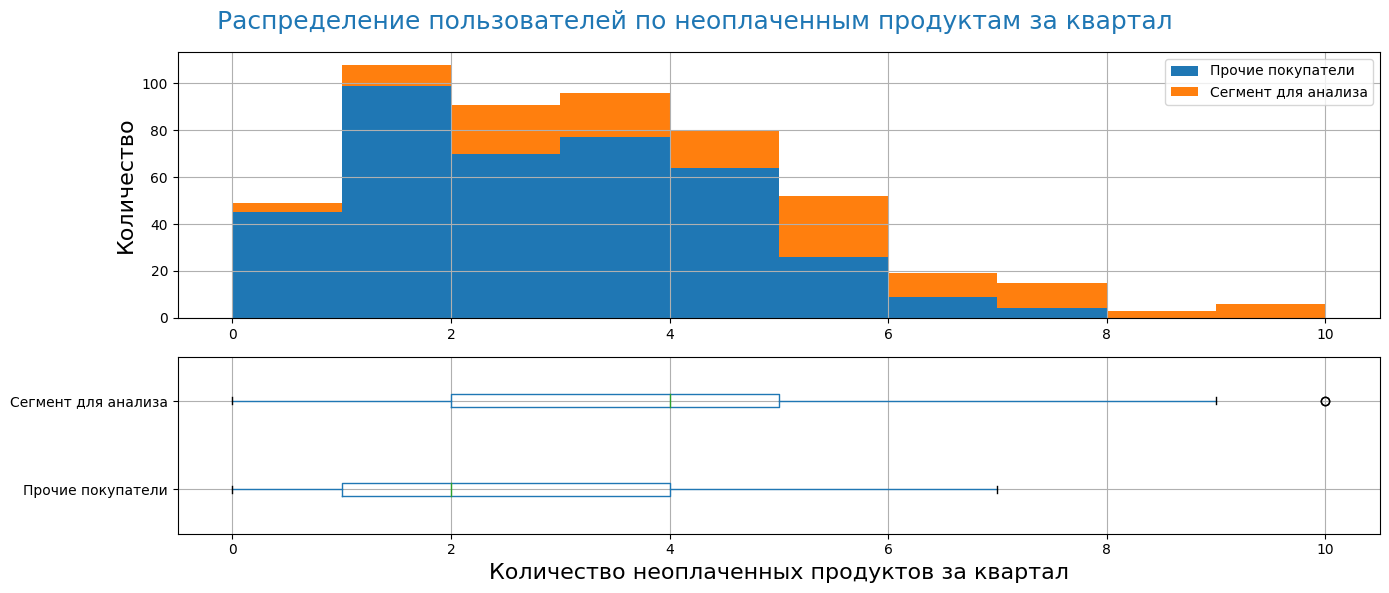

count      mean       std  min  25%  50%  75%   max  \
Сегмент                                                                    
Прочие покупатели    394.0  2.380711  1.621181  0.0  1.0  2.0  4.0   7.0   
Сегмент для анализа  125.0  4.152000  2.254229  0.0  2.0  4.0  5.0  10.0   

                         Gaussian       p_value  
Сегмент                                          
Прочие покупатели    Probably NOT  4.626556e-12  
Сегмент для анализа  Probably NOT  1.730650e-03

In [73]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="неоплаченные_продукты_штук_квартал"
    ),
    "Распределение пользователей по неоплаченным продуктам за квартал",
    "Количество неоплаченных продуктов за квартал", 
    columns="Сегмент", bins=10, boxplot=True, figsize=(14, 6)
)

По анализируемому сегменту заметно большее количество неоплаченных продуктов за прошедший квартал - от 2-х и более 5-ти, в отличие от остальных покупателей, у которых неоплаченных продуктов в основном между 1 и 4.

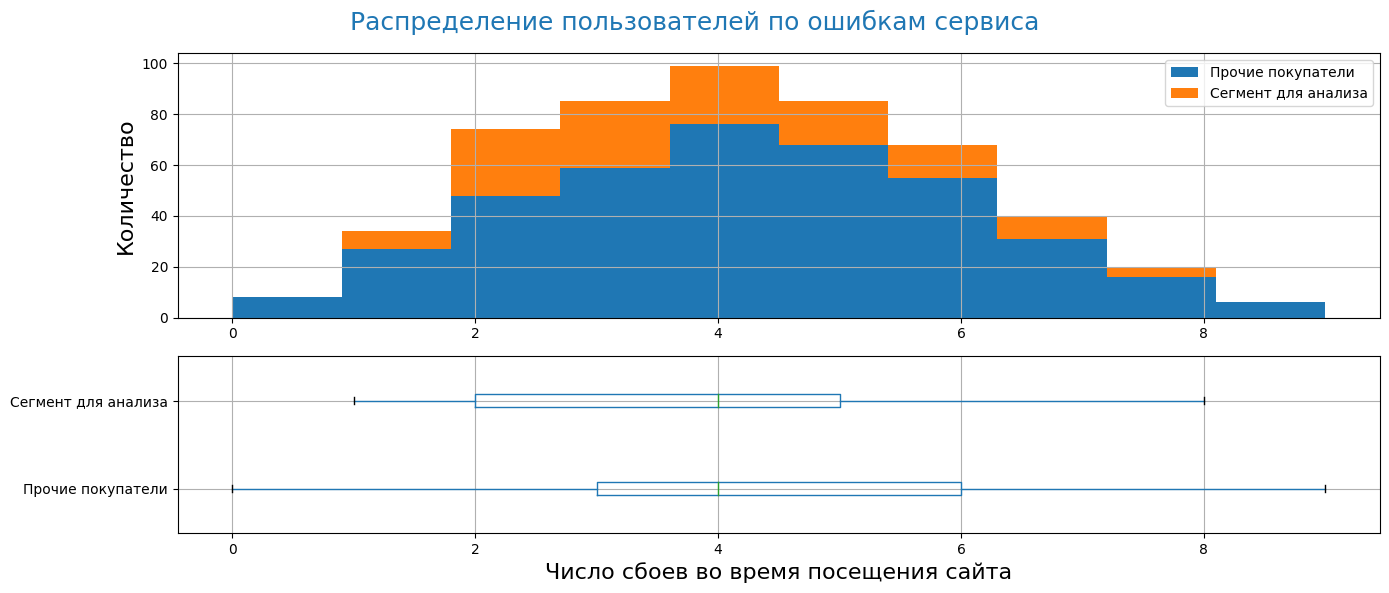

count      mean       std  min  25%  50%  75%  max  \
Сегмент                                                                   
Прочие покупатели    394.0  4.246193  1.999440  0.0  3.0  4.0  6.0  9.0   
Сегмент для анализа  125.0  3.896000  1.808689  1.0  2.0  4.0  5.0  8.0   

                         Gaussian       p_value  
Сегмент                                          
Прочие покупатели    Probably NOT  7.076434e-07  
Сегмент для анализа  Probably NOT  2.209686e-05

In [74]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="ошибка_сервиса"
    ),
    "Распределение пользователей по ошибкам сервиса",
    "Число сбоев во время посещения сайта", 
    columns="Сегмент", bins=10, boxplot=True, figsize=(14, 6)
)

Анализируемый сегмент покупателей в среднем имеют на одну ошибку сервиса меньше.

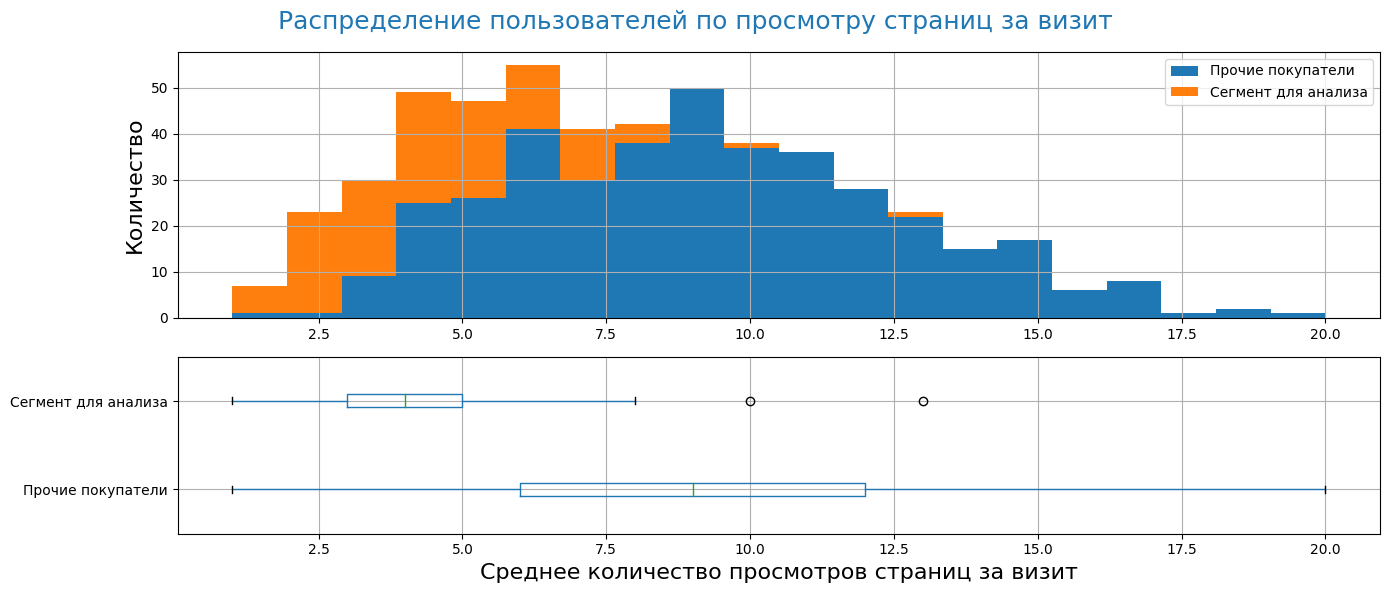

count      mean       std  min  25%  50%   75%   max  \
Сегмент                                                                     
Прочие покупатели    394.0  9.215736  3.554971  1.0  6.0  9.0  12.0  20.0   
Сегмент для анализа  125.0  4.240000  2.033589  1.0  3.0  4.0   5.0  13.0   

                         Gaussian   p_value  
Сегмент                                      
Прочие покупатели    Probably NOT  0.000021  
Сегмент для анализа  Probably NOT  0.000010

In [75]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="страниц_за_визит"
    ),
    "Распределение пользователей по просмотру страниц за визит",
    "Среднее количество просмотров страниц за визит", 
    columns="Сегмент", bins=20, boxplot=True, figsize=(14, 6)
)

По просмотрам за визит заметно очень большое расхождение, анализируемый сегмент имеет существенно меньшее количество просмотров за визит относительно остальных покупателей.

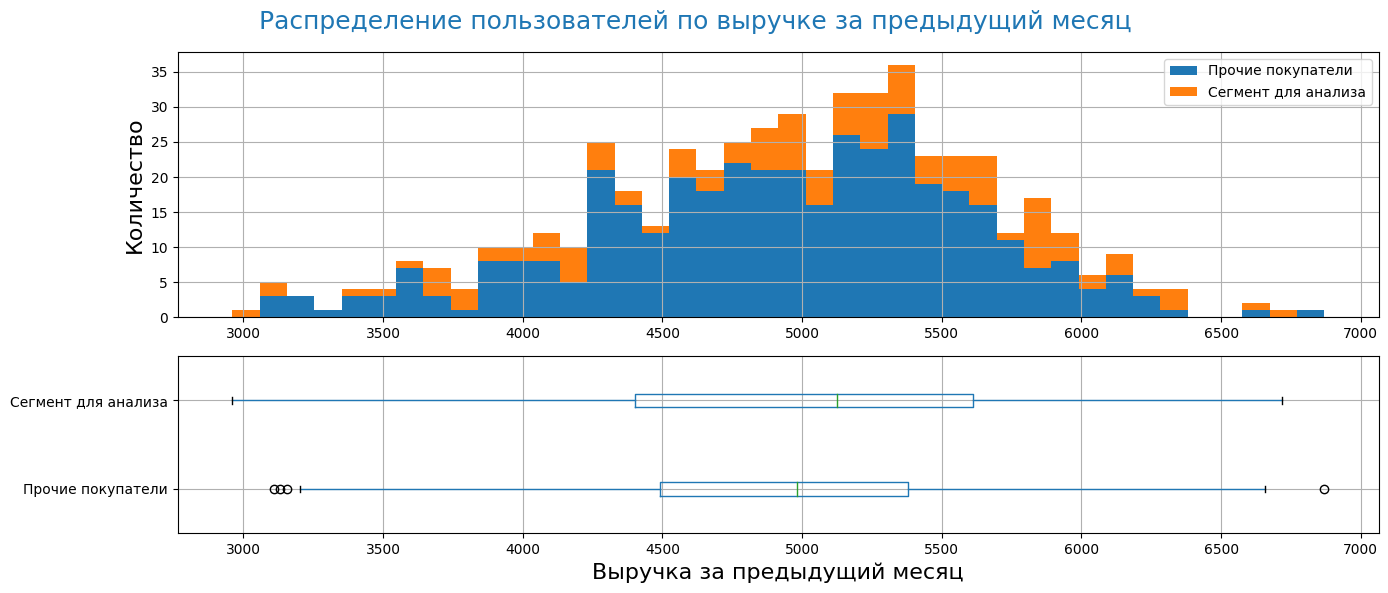

count         mean         std     min       25%  \
Сегмент                                                                 
Прочие покупатели    394.0  4926.480964  669.529106  3111.0  4492.125   
Сегмент для анализа  125.0  5007.480000  810.805388  2960.0  4401.500   

                         50%       75%     max      Gaussian   p_value  
Сегмент                                                                 
Прочие покупатели    4981.25  5378.375  6869.5  Probably NOT  0.004883  
Сегмент для анализа  5126.00  5612.000  6716.5      Probably  0.061584

In [76]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="выручка_предыдущий_месяц"
    ),
    "Распределение пользователей по выручке за предыдущий месяц",
    "Выручка за предыдущий месяц", 
    columns="Сегмент", bins=40, boxplot=True, figsize=(14, 6)
)

Выручка от пользователей за предыдущий месяц в среднем чуть более высокая у пользователей с высоким риском снижения активности.

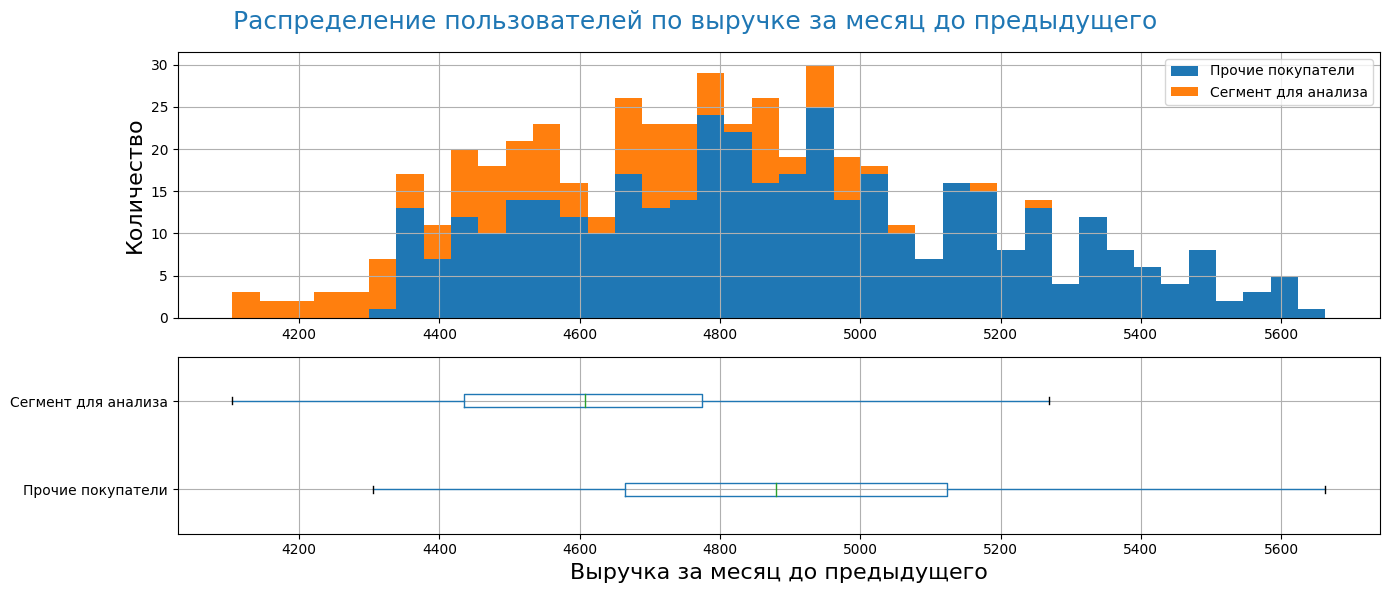

count         mean         std     min     25%     50%  \
Сегмент                                                                       
Прочие покупатели    394.0  4897.246193  313.602937  4305.0  4664.0  4880.5   
Сегмент для анализа  125.0  4610.136000  242.316919  4105.0  4435.0  4607.0   

                        75%     max      Gaussian   p_value  
Сегмент                                                      
Прочие покупатели    5124.0  5663.0  Probably NOT  0.000053  
Сегмент для анализа  4774.0  5269.0      Probably  0.443635

In [77]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="выручка_препредыдущий_месяц"
    ),
    "Распределение пользователей по выручке за месяц до предыдущего",
    "Выручка за месяц до предыдущего", 
    columns="Сегмент", bins=40, boxplot=True, figsize=(14, 6)
)

За препредыдущий месяц заметно более сильное отклонение между анализируемым сегментом и остальными покупателями в меньшую сторону. Разница в средних значениях составляет 200-300 единиц в меньшую сторону, при этом в анализируемом сегменте отсутствуют пользователи со значением выручки выше 5300, в отличие от остальных пользователей, нижняя граница у которых приходится на значения выше 4300 и доходит до более 5600.

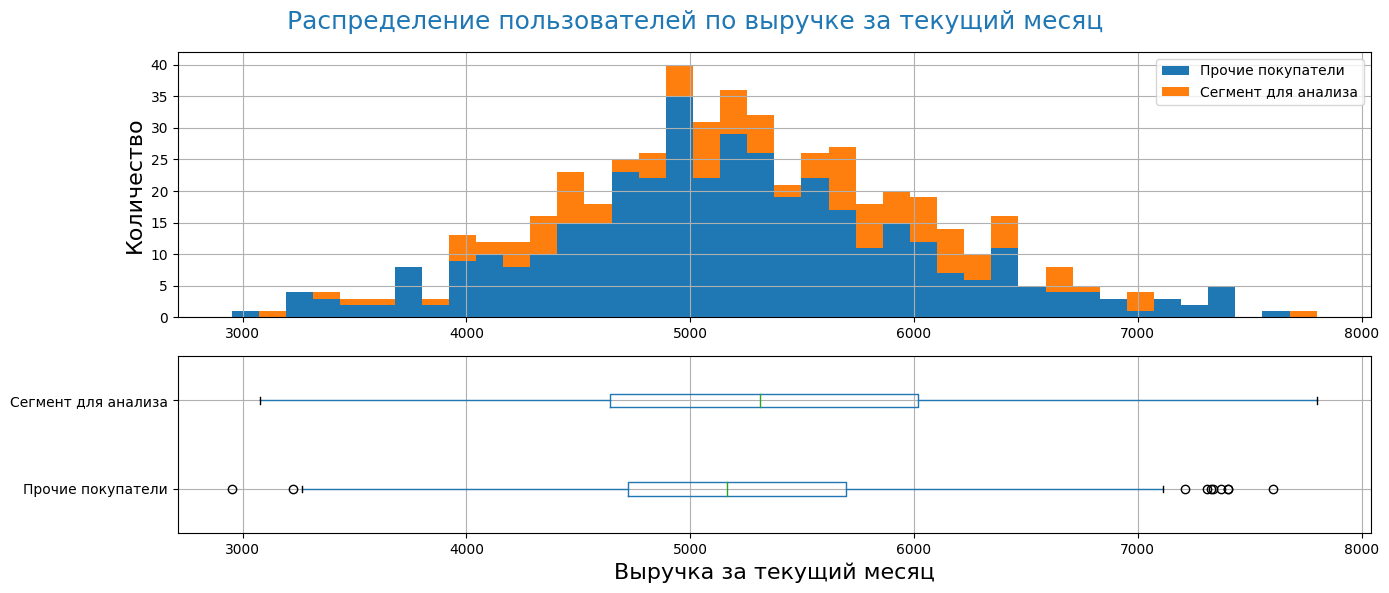

count         mean         std     min     25%     50%  \
Сегмент                                                                       
Прочие покупатели    394.0  5201.223096  831.855582  2952.2  4721.5  5165.2   
Сегмент для анализа  125.0  5329.755200  878.049507  3078.3  4640.8  5310.1   

                        75%     max      Gaussian   p_value  
Сегмент                                                      
Прочие покупатели    5694.1  7605.3  Probably NOT  0.021613  
Сегмент для анализа  6016.9  7799.4      Probably  0.678945

In [78]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="выручка_текущий_месяц"
    ),
    "Распределение пользователей по выручке за текущий месяц",
    "Выручка за текущий месяц", 
    columns="Сегмент", bins=40, boxplot=True, figsize=(14, 6)
)

В текущем месяце заметен больший разброс по значениям, также можно отметить, что анализируемый сегмент показывает большую выручку по сравнению с остальными покупателями, но также и больший разброс по значениям выручки.

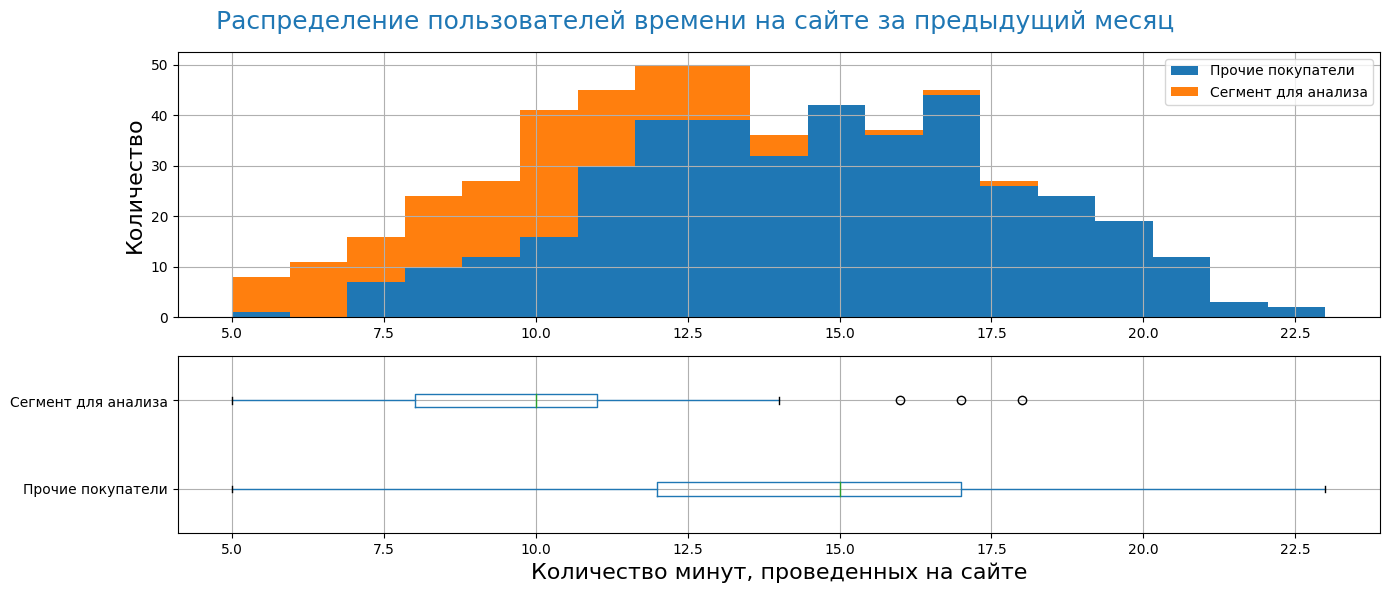

count       mean       std  min   25%   50%   75%   max  \
Сегмент                                                                        
Прочие покупатели    394.0  14.662437  3.515181  5.0  12.0  15.0  17.0  23.0   
Сегмент для анализа  125.0   9.664000  2.633359  5.0   8.0  10.0  11.0  18.0   

                         Gaussian   p_value  
Сегмент                                      
Прочие покупатели    Probably NOT  0.000814  
Сегмент для анализа  Probably NOT  0.005772

In [79]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="минут_предыдущий_месяц"
    ),
    "Распределение пользователей времени на сайте за предыдущий месяц",
    "Количество минут, проведенных на сайте", 
    columns="Сегмент", bins=19, boxplot=True, figsize=(14, 6)
)

По проведенному времени на сайте в предыдущем месяце заметно достаточно сильно отклонение покупателей из анализируемого сегмента в меньшую сторону - в среднем 8-11 минут, в отличие от остальных покупателей основная масса которых проводила 12-17 минут на сайте.

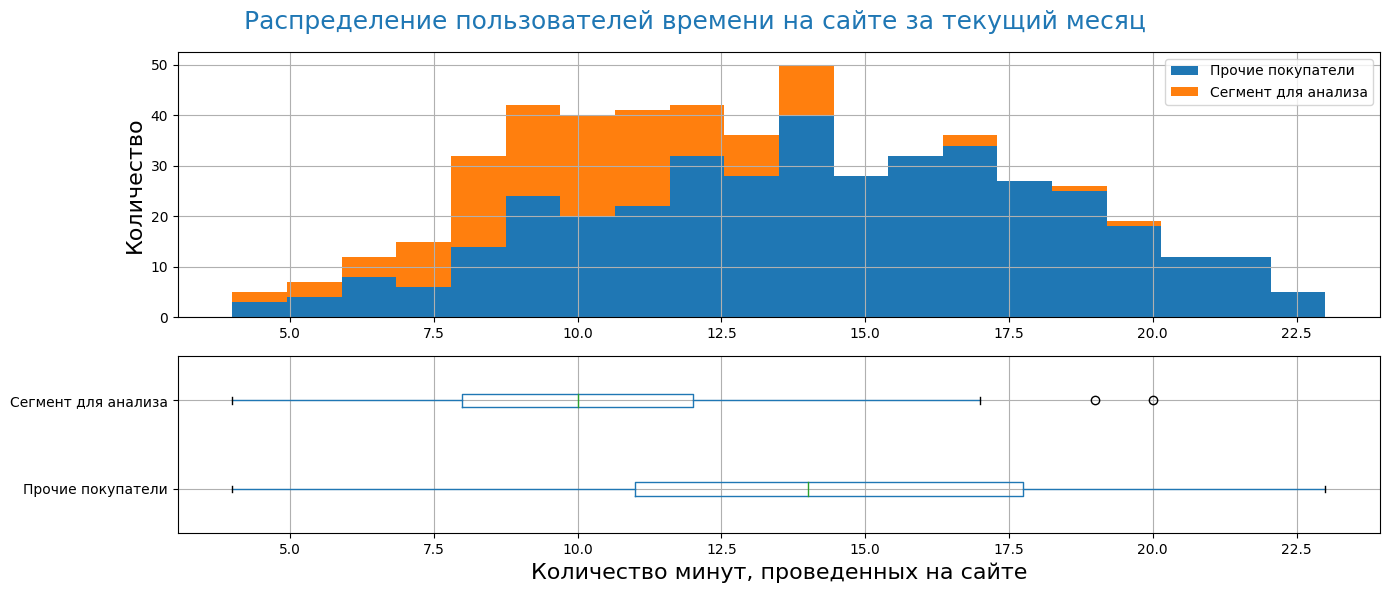

count       mean       std  min   25%   50%    75%   max  \
Сегмент                                                                         
Прочие покупатели    394.0  14.370558  4.245009  4.0  11.0  14.0  17.75  23.0   
Сегмент для анализа  125.0  10.096000  2.769139  4.0   8.0  10.0  12.00  20.0   

                         Gaussian   p_value  
Сегмент                                      
Прочие покупатели    Probably NOT  0.000372  
Сегмент для анализа  Probably NOT  0.001185

In [80]:
show_hist(
    pred_values.pivot(
        columns="сегмент", values="минут_текущий_месяц"
    ),
    "Распределение пользователей времени на сайте за текущий месяц",
    "Количество минут, проведенных на сайте", 
    columns="Сегмент", bins=20, boxplot=True, figsize=(14, 6)
)

В текущем месяце время, проведенное на сайте показывает близкое соотношение - 8-11 минут для целевого сегмента против 11-17 минут для остальных покупателей.

### Промежуточные выводы

Проведена сегментация пользователей, целевым сегментом выбраны пользователи, вероятность определения которых как пользователей со снижением покупательской активности превышает 75%, а также прибыль от которых превышает 3. Были исключены покупатели, приносящие невысокую прибыль, при этом для вероятности 75% достаточно малая доля ложно-положительных предсказаний.

Проведен анализ целевого сегмента, по результатам которого можно сделать следующие предложения:
1. Необходимо провести анализ причин довольно высокого влияния популярных категорий у покупателей на снижение пользовательской активности, в том числе в разрезе проводимых маркетинговых мероприятий, использования таргетированной рекламы, ассортимента продукции по каждой категории и пр.
2. Возможно увеличение маркетинговой активности снизит риск снижения пользовательской активности для следующих пользователей:
    - которые проводят меньше времени на сайте, совершают меньше переходов по категориям и в среднем меньше просматривают страниц;
    - выручка от которых снизилась три месяца назад;
3. Рассмотреть текущую акционную политику, возможно какие-то изменения могли повлиять на снижение пользовательской активности, так как довольно большое количество пользователей с высоким соотношением покупок имеют высокую вероятность снижения пользовательской активности.
4. Необходимо изучить причины неоплаты продуктов, величина которых также влияет на вероятность снижения пользовательской активности. В том числе, возможны какие-либо проблемы при попытке совершить покупку, не связанные с сервисом, такие как проблемы с системой оплаты, либо юзабилити сервиса, что могло привести к сложностям при осуществлении покупок.

## Итоговые выводы

Для решения задачи персонализации предложений постоянным клиентам интернет-магазина "В один клик" в целях увеличения покупательской активности проведено исследование данных, построена модель машинного обучения и проведено исследование пользовательского сегмента.

На начальном этапе проведена загрузка полученных данных:
- файл market_file.csv содержит 1300 записей о поведении покупателя на сайте, коммуникациях с покупателем и его продуктовом поведении. Пропуски в данных отсутствуют.
- файл market_money.csv содержит 3900 записей о выручке, которую получает магазин с покупателя за последние 3 месяца. Пропуски отсустствуют.
- файл market_time.csv содержит 2600 записей о времени (в минутах), которое покупатель провёл на сайте за последние 2 месяца. Пропуски отсутствуют.
- файл money.csv содержит 1300 записей о среднемесячной прибыли покупателя за последние 3 месяца. Пропуски отсутствуют

Проведена предобработка данных, по результатам которых: 
1. Названия столбцов приведены к единому стилю;
2. Выявлено аномальное значение выручки у пользователя id 215380 за текущий месяц, равное 106862.2, значение было изменено на '0' для дальнейшего исключения.

Пользователи, покупательская активность которых составляет менее 3-х месяцев были исключены из выборки.

Проведен исследовательский анализ данных, по результатам которого можно отметить следующее:
1. По целевому признаку имеется дисбаланс данных, пользователей со снизившейся активностью почти на половину меньше чем пользователей с прежним уровнем активности.
2. Заметно высокое отношение покупателей со снизившейся активностью у премиум подписчиков.
3. По популярным категориям имеются большие расхождения по соотношению пользователей в разрезе пользовательской активности - самое низкое соотношение пользователей со снизившейся активностью в категориях 'Мелкая бытовая техника и электроника' и 'Техника для красоты и здоровья', самое высокое соотношение - 'Кухонная посуда', 'Косметика и аксесуары' и 'Товары для детей'.
4. Можно также отметить о вероятной зависимости целевого признака пользовательской активности со следующими признаками:
    - маркетинговая активность за 6 месяцев, чем она выше, тем ниже отношение пользователей со снизившейся активностью;
    - отношение покупок по акции - чем больше таких покупок, тем выше пользователей со снизившеся активностью;
    - среднее количество просмотров категорий за визит - чем больше просмотров, тем ниже отношение пользователей со снизившейся активностью;
    - количество неоплаченных продуктов - чем больше продуктов, тем выше отношение пользователей со снизившейся активностью;
    - среднее количество страниц за визит - чем больше страниц, тем ниже отношение пользователей со снизившейся активностью.

Проведено объединение таблиц, после которого выявились полные дубликаты в данных в количестве 11 штук. Дубликаты не были исключены из итоговой выборки, так как все они принадлежат к минорному классу по целевому признаку, что больше усилило бы дисбаланс классов. Общее количество данных после объединения составляет 1296 пользователей и 17 признаков.

Проведен корреляционный анализ, по результатам которого можно отметить следующее:
1. По ключевому признаку высокая корреляция наблюдается только с количеством страниц за визит - 0.75, также заметная корреляция со следующими признаками:
    - временем на сайте за предыдущий и текущий месяц - 0.685 и 0.577 соответственно;
    - средняя маркетинговая активность на сайте за 6 месяцев и средний просмотр категорий за визит - 0.545 и 0.54 соответственно;
    - акционные покупки и неоплаченные продукты - 0.506 с каждым признаком.
2. Между признаками имеется высокая корреляция только по признакам выручка за текущий месяц и выручка за предыдущий месяц - 0.836, по остальным признакам низкая либо умеренная корреляция ниже 0.5.
3. По покупателям со снизившейся пользовательской активностью возрастает между признаками выручки за текущий и предыдущий месяц до 0.872, также заметно вырастает корреляция между признаками:
    - сраниц за визит и проведенным временем на сайте - 0.633 за предыдущий месяц и 0.488 за текущий, 
    - выручка за препредыдущий месяц и временем на сайте - 0.598 за текущий месяц и 0.55 за предыдущий;
    - временем на сайте за текущий и предыдущий месяц - 0.559.
4. По покупателям с прежней пользовательской активностью корреляция между признаками сильно снижается, при этом корреляция возрастает между признаками выручки, в том числе за предыдущий и текущий месяц до 0.867, а также появляется умеренная корреляция между выручкой за текущий месяц и препредыдущий месяц - 0.498 и между выручкой за предыдущий и препредыдущий месяцы до 0.419.

В качестве наиболее подходящей метрики выбрана метрика ROC-AUC так как имеется несбалансированная выборка для задачи бинарной классификации.

Подготовлен пайплайн который производит подготовку данных и используется для автоматизированного поиска наилучшей модели с помощью RandomizedSearchCV:
1. Все категориальные признаки кодировались с помощью OneHotEncoder, целевой кодировался предварительное LabelEncoder;
2. При кодировании пустые значения заполняются самыми распространенными значениями признаков (мода).
3. Количественные признаки кодировались с помощью StandardScaler, MinMaxScaler, RobustScaler, либо использовались без кодирования.
4. Для поиска налиучшей использовались модели `k-ближайших соседей`, `Дерево решений`, `Логистическая регрессия` и `Метод опорных векторов`.

По результатам поиска наилучшей моделью определен метод опорных векторов со стандартным ядром rbf и параметром регуляризации равным 1. Значение метрики ROC-AUC в среднем составило довольно высокое значение - 0.913 при кросс-валидации на тренировочной выборке. Для тестовой выборки данная метрика показывает более высокое значение - 0.918. Также довольно высокие показатели у моделей логистической регрессии, SVM с ядром `poly` или `sigmoid` при кросс-валидации.

Проведен анализ важности признаков обученных моделей:
1. Наиболее важными признаками, влияющими на снижение пользовательской активности, являются акционные покупки и средний просмотр категорий за визит, страниц за визит и неоплаченные продукты за квартал, а также немаловажным фактором является количество неоплаченных продуктов за квартал.
2. Достаточно важными признаками можно отметить количество минут на сайте в текущем и предыдущем месяцах, маркетинговая активность за 6 месяцев, а также выручка за месяц до предыдущего.
3. Также достаточное влияние оказывают популярные категории - мелкая бытовая техника и электроника, а также техника для красоты и здоровья.
4. Остальные признаки в целом имеют определенное влияние, очень низкое влияние оказывает длительность регистрации и тип сервиса и маркетинговая активность текущего месяца.

Можно определить предварительный портрет пользователя, активность которого снижается:
1. Более высокое количество неоплаченных продуктов за квартал и высокая доля акционных покупок за последние пол года.
2. В целом низкие показатели количества просмотров категорий и страниц за визит, а также низкое количество минут на сайте за предыдущий и текущий месяцы, а также низкая маркетинговая активность за пол года и низкий показатель выручки за месяц до предыдущего.

Проведена сегментация пользователей, целевым сегментом выбраны пользователи, вероятность определения которых как пользователей со снижением покупательской активности превышает 80%, а также прибыль от которых превышает 3. Были исключены покупатели, приносящие невысокую прибыль, при этом для вероятности 80% достаточно малая доля ложно-положительных предсказаний.

Проведен анализ целевого сегмента, по результатам которого можно сделать следующие предложения:
1. Необходимо провести анализ причин довольно высокого влияния популярных категорий у покупателей на снижение пользовательской активности, в том числе в разрезе проводимых маркетинговых мероприятий, использования таргетированной рекламы, ассортимента продукции по каждой категории и пр.
2. Возможно увеличение маркетинговой активности снизит риск снижения пользовательской активности для следующих пользователей:
    - которые проводят меньше времени на сайте, совершают меньше переходов по категориям и в среднем меньше просматривают страниц;
    - выручка от которых снизилась три месяца назад;
3. Рассмотреть текущую акционную политику, возможно какие-то изменения могли повлиять на снижение пользовательской активности, так как довольно большое количество пользователей с высоким соотношением покупок имеют высокую вероятность снижения пользовательской активности.
4. Необходимо изучить причины неоплаты продуктов, величина которых также влияет на вероятность снижения пользовательской активности. В том числе, возможны какие-либо проблемы при попытке совершить покупку, не связанные с сервисом, такие как проблемы с системой оплаты, либо юзабилити сервиса, что могло привести к сложностям при осуществлении покупок.